In [1]:
# ==========================================
# 📦 Import Libraries — Data Science Project
# ==========================================

# Core data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning & feature selection
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

# Warnings (optional: suppress to keep notebook clean)
import warnings
warnings.filterwarnings("ignore")

# Display settings for readability
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

print("✅ All libraries successfully imported.")


✅ All libraries successfully imported.


In [2]:
import pandas as pd

# Load data (already done before, but safe to re-run)
df = pd.read_csv("../Data_Assets/Most-Recent-Cohorts-Institution.csv", dtype=str)

# 1️⃣ Basic structure
print("Shape (rows, columns):", df.shape)
print("\nColumn Names Sample:\n", df.columns[:20].tolist())  # show first 20 column names

# 2️⃣ Inspect data types (first 10 columns) now the rows are individual universities 
df.info(verbose=True, show_counts=True)


Shape (rows, columns): (6429, 3306)

Column Names Sample:
 ['UNITID', 'OPEID', 'OPEID6', 'INSTNM', 'CITY', 'STABBR', 'ZIP', 'ACCREDAGENCY', 'INSTURL', 'NPCURL', 'SCH_DEG', 'HCM2', 'MAIN', 'NUMBRANCH', 'PREDDEG', 'HIGHDEG', 'CONTROL', 'ST_FIPS', 'REGION', 'LOCALE']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6429 entries, 0 to 6428
Data columns (total 3306 columns):
 #     Column                            Non-Null Count  Dtype 
---    ------                            --------------  ----- 
 0     UNITID                            6429 non-null   object
 1     OPEID                             6405 non-null   object
 2     OPEID6                            6405 non-null   object
 3     INSTNM                            6429 non-null   object
 4     CITY                              6429 non-null   object
 5     STABBR                            6429 non-null   object
 6     ZIP                               6429 non-null   object
 7     ACCREDAGENCY                      6225 non-

## Integrate IPEDS Demographic & Aid Data
To honor the project description (Scorecard + IPEDS + FSA/Census), we begin by merging the freshly downloaded IPEDS custom file into the Scorecard dataframe using `UNITID`/`OPEID`. This keeps the rest of the EDA steps in sync with the six-step guideline.


In [3]:
# Load IPEDS extract (Final 2023 release) and normalize column names
def clean_column_names(columns):
    return (columns
            .str.strip()
            .str.replace('[^0-9a-zA-Z]+', '_', regex=True)
            .str.upper())

ipeds_path = "../Data_Assets/external/ipeds/CSV_11262025-608/ipeds_final_2023.csv"
ipeds_raw = pd.read_csv(ipeds_path, dtype=str)
ipeds_raw.columns = clean_column_names(ipeds_raw.columns)

# Friendly column aliases so downstream code can reference concise names
friendly_map = {
    "SFA2223_PERCENT_OF_FULL_TIME_FIRST_TIME_UNDERGRADUATES_AWARDED_PELL_GRANTS": "PELL_PCT_FTFT",
    "SFA2223_AVERAGE_AMOUNT_OF_PELL_GRANT_AID_AWARDED_TO_FULL_TIME_FIRST_TIME_UNDERGRADUATES": "PELL_AVG_AID",
    "SFA2223_PERCENT_OF_FULL_TIME_FIRST_TIME_UNDERGRADUATES_AWARDED_FEDERAL_STUDENT_LOANS": "LOAN_PCT_FTFT",
    "SFA2223_AVERAGE_AMOUNT_OF_FEDERAL_STUDENT_LOANS_AWARDED_TO_FULL_TIME_FIRST_TIME_UNDERGRADUATES": "LOAN_AVG_AID",
    "SFA2223_NUMBER_OF_UNDERGRADUATE_STUDENTS_AWARDED_FEDERAL_PELL_GRANTS": "PELL_RECIPIENTS",
    "SFA2223_AVERAGE_NET_PRICE_INCOME_0_30_000_STUDENTS_AWARDED_TITLE_IV_FEDERAL_FINANCIAL_AID_2022_23": "NETPRICE_INCOME_0_30",
    "SFA2223_AVERAGE_NET_PRICE_INCOME_30_001_48_000_STUDENTS_AWARDED_TITLE_IV_FEDERAL_FINANCIAL_AID_2022_23": "NETPRICE_INCOME_30_48",
    "SFA2223_AVERAGE_NET_PRICE_INCOME_48_001_75_000_STUDENTS_AWARDED_TITLE_IV_FEDERAL_FINANCIAL_AID_2022_23": "NETPRICE_INCOME_48_75",
    "SFA2223_AVERAGE_NET_PRICE_INCOME_75_001_110_000_STUDENTS_AWARDED_TITLE_IV_FEDERAL_FINANCIAL_AID_2022_23": "NETPRICE_INCOME_75_110",
    "SFA2223_AVERAGE_NET_PRICE_INCOME_OVER_110_000_STUDENTS_AWARDED_TITLE_IV_FEDERAL_FINANCIAL_AID_2022_23": "NETPRICE_INCOME_GT_110",
    "DRVEF2023_PERCENT_OF_UNDERGRADUATE_ENROLLMENT_THAT_ARE_TWO_OR_MORE_RACES": "UG_TWOORMORE_PCT",
    "DRVEF2023_PERCENT_OF_UNDERGRADUATE_ENROLLMENT_THAT_ARE_RACE_ETHNICITY_UNKNOWN": "UG_RACE_UNKNOWN_PCT",
    "DRVEF122023_RV_PERCENT_OF_UNDERGRADUATE_12_MONTH_UNDUPLICATED_HEADCOUNT_THAT_ARE_TWO_OR_MORE_RACES": "UNDUP_TWOORMORE_PCT",
    "DRVEF122023_RV_PERCENT_OF_UNDERGRADUATE_12_MONTH_UNDUPLICATED_HEADCOUNT_THAT_ARE_RACE_ETHNICITY_UNKNOWN": "UNDUP_RACE_UNKNOWN_PCT",
    "ADM2023_APPLICANTS_ANOTHER_GENDER": "APPLICANTS_OTHER_GENDER",
    "ADM2023_ADMISSIONS_ANOTHER_GENDER": "ADMISSIONS_OTHER_GENDER"
}
ipeds_raw = ipeds_raw.rename(columns=friendly_map)

# De-duplicate similarly named institution columns for clarity
alias_map = {}
if "INSTITUTION_NAME" in ipeds_raw.columns:
    alias_map["INSTITUTION_NAME"] = "INSTNM_IPEDS_PRIMARY"
if "INSTITUTION_NAME_1" in ipeds_raw.columns:
    alias_map["INSTITUTION_NAME_1"] = "INSTNM_IPEDS_ALT"
if alias_map:
    ipeds_raw = ipeds_raw.rename(columns=alias_map)

# Ensure join keys are strings
ipeds_raw["UNITID"] = ipeds_raw["UNITID"].astype(str)
df["UNITID"] = df["UNITID"].astype(str)

# Merge (left join keeps all Scorecard institutions)
df = df.merge(ipeds_raw, on="UNITID", how="left", validate="one_to_one", suffixes=("", "_IPEDS"))
print(f"✅ IPEDS columns merged. New shape: {df.shape}")


✅ IPEDS columns merged. New shape: (6429, 3330)


In [4]:
# Merge AY22-23 Pell Grant aggregates (institution-level)
pell_path = "../22-23 Pell Grants/pell_grants_ay2022_2023_fullyear.csv"
pell_df = pd.read_csv(pell_path, dtype={"OPEID": str})

pell_df = pell_df.rename(columns={
    "FEDERAL PELL GRANT PROGRAM__Sum of Recipients": "PELL_RECIPIENTS_TOTAL",
    "FEDERAL PELL GRANT PROGRAM__Sum of Disbursements": "PELL_DISBURSEMENTS_TOTAL",
    "TEACH PROGRAM__Sum of Recipients": "TEACH_RECIPIENTS_TOTAL",
    "TEACH PROGRAM__Sum of Disbursements": "TEACH_DISBURSEMENTS_TOTAL",
    "IRAQ AFGHANISTAN SERVICE GRANT PROGRAM__Sum of Recipients": "IASG_RECIPIENTS_TOTAL",
    "IRAQ AFGHANISTAN SERVICE GRANT PROGRAM__Sum of Disbursements": "IASG_DISBURSEMENTS_TOTAL"
})

pell_numeric_cols = [
    "PELL_RECIPIENTS_TOTAL", "PELL_DISBURSEMENTS_TOTAL",
    "TEACH_RECIPIENTS_TOTAL", "TEACH_DISBURSEMENTS_TOTAL",
    "IASG_RECIPIENTS_TOTAL", "IASG_DISBURSEMENTS_TOTAL",
    "quarters_reporting"
]
for col in pell_numeric_cols:
    pell_df[col] = pd.to_numeric(pell_df[col], errors="coerce")

pell_df["OPEID"] = pell_df["OPEID"].astype(str).str.zfill(8)
df["OPEID"] = df["OPEID"].astype(str).str.zfill(8)

pell_merge_cols = ["OPEID"] + pell_numeric_cols

df = df.merge(
    pell_df[pell_merge_cols],
    on="OPEID",
    how="left",
    validate="many_to_one",
    suffixes=("", "_PELL")
)
print(f"📘 Pell grant data merged. Shape: {df.shape}")


📘 Pell grant data merged. Shape: (6429, 3337)


In [5]:
# Merge AY22-23 Direct Loan dashboard aggregates
loan_path = "../Data_Assets/external/fsa/dl_dashboard_ay2022_2023_fullyear.csv"
loan_df = pd.read_csv(loan_path, dtype={"OPEID": str})

loan_df = loan_df.rename(columns={
    "DL SUBSIDIZED__Recipients": "DL_SUB_RECIPIENTS",
    "DL SUBSIDIZED__# of Loans Originated": "DL_SUB_LOANS",
    "DL SUBSIDIZED__$ of Loans Originated": "DL_SUB_ORIGINATION",
    "DL SUBSIDIZED__# of Disbursements": "DL_SUB_DISB_COUNT",
    "DL SUBSIDIZED__$ of Disbursements": "DL_SUB_DISBURSEMENTS",
    "DL UNSUBSIDIZED - UNDERGRADUATE__Recipients": "DL_UNDERGRAD_RECIPIENTS",
    "DL UNSUBSIDIZED - UNDERGRADUATE__# of Loans Originated": "DL_UNDERGRAD_LOANS",
    "DL UNSUBSIDIZED - UNDERGRADUATE__$ of Loans Originated": "DL_UNDERGRAD_ORIGINATION",
    "DL UNSUBSIDIZED - UNDERGRADUATE__# of Disbursements": "DL_UNDERGRAD_DISB_COUNT",
    "DL UNSUBSIDIZED - UNDERGRADUATE__$ of Disbursements": "DL_UNDERGRAD_DISBURSEMENTS",
    "DL UNSUBSIDIZED - GRADUATE__Recipients": "DL_GRAD_RECIPIENTS",
    "DL UNSUBSIDIZED - GRADUATE__# of Loans Originated": "DL_GRAD_LOANS",
    "DL UNSUBSIDIZED - GRADUATE__$ of Loans Originated": "DL_GRAD_ORIGINATION",
    "DL UNSUBSIDIZED - GRADUATE__# of Disbursements": "DL_GRAD_DISB_COUNT",
    "DL UNSUBSIDIZED - GRADUATE__$ of Disbursements": "DL_GRAD_DISBURSEMENTS",
    "DL PARENT PLUS__Recipients": "DL_PARENT_PLUS_RECIPIENTS",
    "DL PARENT PLUS__# of Loans Originated": "DL_PARENT_PLUS_LOANS",
    "DL PARENT PLUS__$ of Loans Originated": "DL_PARENT_PLUS_ORIGINATION",
    "DL PARENT PLUS__# of Disbursements": "DL_PARENT_PLUS_DISB_COUNT",
    "DL PARENT PLUS__$ of Disbursements": "DL_PARENT_PLUS_DISBURSEMENTS",
    "DL GRAD PLUS__Recipients": "DL_GRAD_PLUS_RECIPIENTS",
    "DL GRAD PLUS__# of Loans Originated": "DL_GRAD_PLUS_LOANS",
    "DL GRAD PLUS__$ of Loans Originated": "DL_GRAD_PLUS_ORIGINATION",
    "DL GRAD PLUS__# of Disbursements": "DL_GRAD_PLUS_DISB_COUNT",
    "DL GRAD PLUS__$ of Disbursements": "DL_GRAD_PLUS_DISBURSEMENTS"
})

loan_numeric_cols = [col for col in loan_df.columns if col not in ["OPEID", "School", "State", "ZipCode", "SchoolType"]]
loan_df[loan_numeric_cols] = loan_df[loan_numeric_cols].apply(pd.to_numeric, errors="coerce")

loan_df["DL_TOTAL_RECIPIENTS"] = loan_df[[
    "DL_SUB_RECIPIENTS", "DL_UNDERGRAD_RECIPIENTS", "DL_GRAD_RECIPIENTS",
    "DL_PARENT_PLUS_RECIPIENTS", "DL_GRAD_PLUS_RECIPIENTS"
]].sum(axis=1, min_count=1)
loan_df["DL_TOTAL_DISBURSEMENTS"] = loan_df[[
    "DL_SUB_DISBURSEMENTS", "DL_UNDERGRAD_DISBURSEMENTS", "DL_GRAD_DISBURSEMENTS",
    "DL_PARENT_PLUS_DISBURSEMENTS", "DL_GRAD_PLUS_DISBURSEMENTS"
]].sum(axis=1, min_count=1)

loan_merge_cols = [
    "OPEID",
    "DL_SUB_RECIPIENTS", "DL_SUB_DISBURSEMENTS",
    "DL_UNDERGRAD_RECIPIENTS", "DL_UNDERGRAD_DISBURSEMENTS",
    "DL_PARENT_PLUS_RECIPIENTS", "DL_PARENT_PLUS_DISBURSEMENTS",
    "DL_GRAD_RECIPIENTS", "DL_GRAD_DISBURSEMENTS",
    "DL_GRAD_PLUS_RECIPIENTS", "DL_GRAD_PLUS_DISBURSEMENTS",
    "DL_TOTAL_RECIPIENTS", "DL_TOTAL_DISBURSEMENTS"
]
loan_df["OPEID"] = loan_df["OPEID"].astype(str).str.zfill(8)

df = df.merge(
    loan_df[loan_merge_cols],
    on="OPEID",
    how="left",
    validate="many_to_one",
    suffixes=("", "_DL")
)
print(f"💸 Direct Loan data merged. Shape: {df.shape}")


💸 Direct Loan data merged. Shape: (6429, 3349)


In [6]:
ipeds_numeric_cols = [
    "PELL_RECIPIENTS", "PELL_PCT_FTFT", "PELL_AVG_AID",
    "LOAN_PCT_FTFT", "LOAN_AVG_AID",
    "NETPRICE_INCOME_0_30", "NETPRICE_INCOME_30_48", "NETPRICE_INCOME_48_75",
    "NETPRICE_INCOME_75_110", "NETPRICE_INCOME_GT_110",
    "UG_TWOORMORE_PCT", "UG_RACE_UNKNOWN_PCT",
    "UNDUP_TWOORMORE_PCT", "UNDUP_RACE_UNKNOWN_PCT",
    "APPLICANTS_OTHER_GENDER", "ADMISSIONS_OTHER_GENDER"
]

for col in ipeds_numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("📊 Converted IPEDS numeric columns where available.")


📊 Converted IPEDS numeric columns where available.


### IPEDS-specific Missingness & Univariate Views
The guideline asks us to summarize structure/quality for every data source we merge. The next cells focus on the new IPEDS variables only (Pell, loan, net price, gender/race).


Missingness (% of institutions) for IPEDS columns:

ADMISSIONS_OTHER_GENDER    97.7
APPLICANTS_OTHER_GENDER    92.8
NETPRICE_INCOME_GT_110     70.9
NETPRICE_INCOME_75_110     67.4
NETPRICE_INCOME_48_75      61.0
NETPRICE_INCOME_30_48      58.1
NETPRICE_INCOME_0_30       50.3
LOAN_AVG_AID               28.8
PELL_AVG_AID               20.3
PELL_PCT_FTFT              19.0
LOAN_PCT_FTFT              19.0
PELL_RECIPIENTS            15.1
UG_RACE_UNKNOWN_PCT        15.0
UG_TWOORMORE_PCT           15.0
UNDUP_RACE_UNKNOWN_PCT     15.0
UNDUP_TWOORMORE_PCT        15.0
dtype: float64


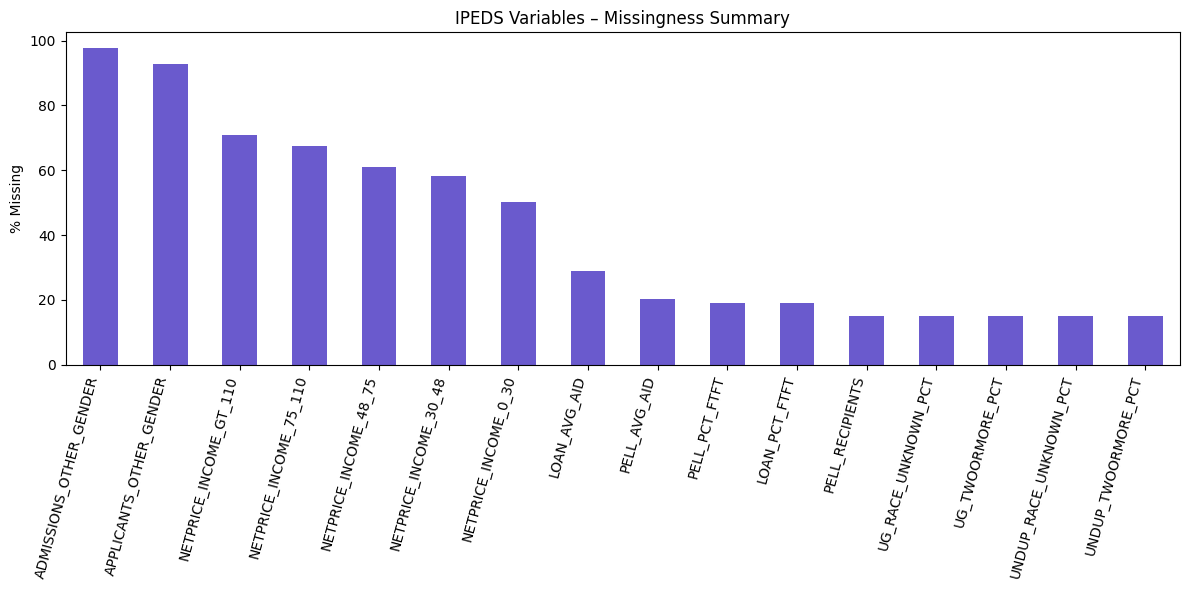

,mean,std,min,max
PELL_RECIPIENTS,946.884735,2221.710352,0.0,66069.0
PELL_PCT_FTFT,52.881912,23.731487,0.0,100.0
PELL_AVG_AID,5248.494145,1055.198702,172.0,10342.0
LOAN_PCT_FTFT,46.894777,31.359009,0.0,100.0
LOAN_AVG_AID,5837.916376,1655.389158,128.0,20000.0
NETPRICE_INCOME_0_30,18920.127034,8371.309400,-4129.0,78201.0
NETPRICE_INCOME_30_48,19619.463994,8509.773289,-2483.0,74499.0
NETPRICE_INCOME_48_75,21519.427545,8468.838607,-123.0,69323.0
NETPRICE_INCOME_75_110,24827.722461,8353.486411,1421.0,112070.0
NETPRICE_INCOME_GT_110,28603.829776,9636.957492,2914.0,79482.0


In [7]:
ipeds_focus_cols = [col for col in ipeds_numeric_cols if col in df.columns]

ipeds_missing = df[ipeds_focus_cols].isna().mean().round(3) * 100
ipeds_missing = ipeds_missing.sort_values(ascending=False)
print("Missingness (% of institutions) for IPEDS columns:\n")
print(ipeds_missing)

plt.figure(figsize=(12, 6))
ipeds_missing.plot(kind='bar', color='slateblue')
plt.ylabel('% Missing')
plt.title('IPEDS Variables – Missingness Summary')
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

ipeds_describe = df[ipeds_focus_cols].describe().T
ipeds_describe[["mean", "std", "min", "max"]]


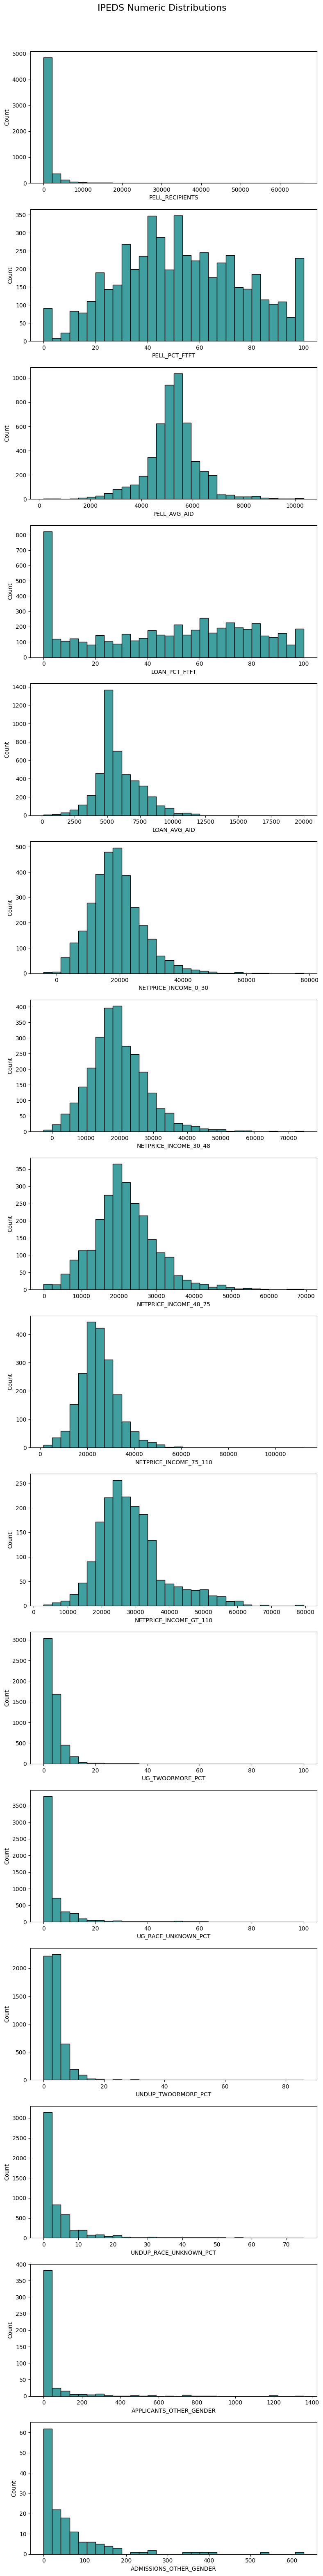

In [8]:
fig, axes = plt.subplots(len(ipeds_focus_cols), 1, figsize=(8, 4*len(ipeds_focus_cols)))
fig.suptitle('IPEDS Numeric Distributions', fontsize=16)

for ax, col in zip(np.ravel(axes), ipeds_focus_cols):
    sns.histplot(df[col].dropna(), ax=ax, bins=30, color='teal')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


### IPEDS-derived feature spotlight
The merged columns capture institutional aid behavior and additional demographics. We summarize their distributions before deciding which to keep for modeling.


In [9]:
ipeds_feature_cols = [
    'PELL_RECIPIENTS', 'PELL_PCT_FTFT', 'PELL_AVG_AID', 'LOAN_PCT_FTFT', 'LOAN_AVG_AID',
    'NETPRICE_INCOME_0_30', 'NETPRICE_INCOME_30_48', 'NETPRICE_INCOME_48_75',
    'NETPRICE_INCOME_75_110', 'NETPRICE_INCOME_GT_110',
    'UG_TWOORMORE_PCT', 'UG_RACE_UNKNOWN_PCT',
    'UNDUP_TWOORMORE_PCT', 'UNDUP_RACE_UNKNOWN_PCT'
]

ipeds_summary = df[ipeds_feature_cols].describe().T
ipeds_summary['missing_pct'] = df[ipeds_feature_cols].isna().mean().round(3) * 100
ipeds_summary


,count,mean,std,min,25%,50%,75%,max,missing_pct
PELL_RECIPIENTS,5457.0,946.884735,2221.710352,0.0,84.00,287.0,862.00,66069.0,15.1
PELL_PCT_FTFT,5208.0,52.881912,23.731487,0.0,36.00,51.0,70.00,100.0,19.0
PELL_AVG_AID,5124.0,5248.494145,1055.198702,172.0,4775.50,5265.5,5730.50,10342.0,20.3
LOAN_PCT_FTFT,5208.0,46.894777,31.359009,0.0,18.00,50.0,73.00,100.0,19.0
LOAN_AVG_AID,4580.0,5837.916376,1655.389158,128.0,4948.75,5435.0,6770.75,20000.0,28.8
NETPRICE_INCOME_0_30,3196.0,18920.127034,8371.309400,-4129.0,13668.25,18272.0,23319.50,78201.0,50.3
NETPRICE_INCOME_30_48,2694.0,19619.463994,8509.773289,-2483.0,14394.75,18787.0,24377.50,74499.0,58.1
NETPRICE_INCOME_48_75,2505.0,21519.427545,8468.838607,-123.0,16391.00,20814.0,26169.00,69323.0,61.0
NETPRICE_INCOME_75_110,2097.0,24827.722461,8353.486411,1421.0,19935.00,24263.0,29438.00,112070.0,67.4
NETPRICE_INCOME_GT_110,1874.0,28603.829776,9636.957492,2914.0,22302.00,26948.0,32861.00,79482.0,70.9


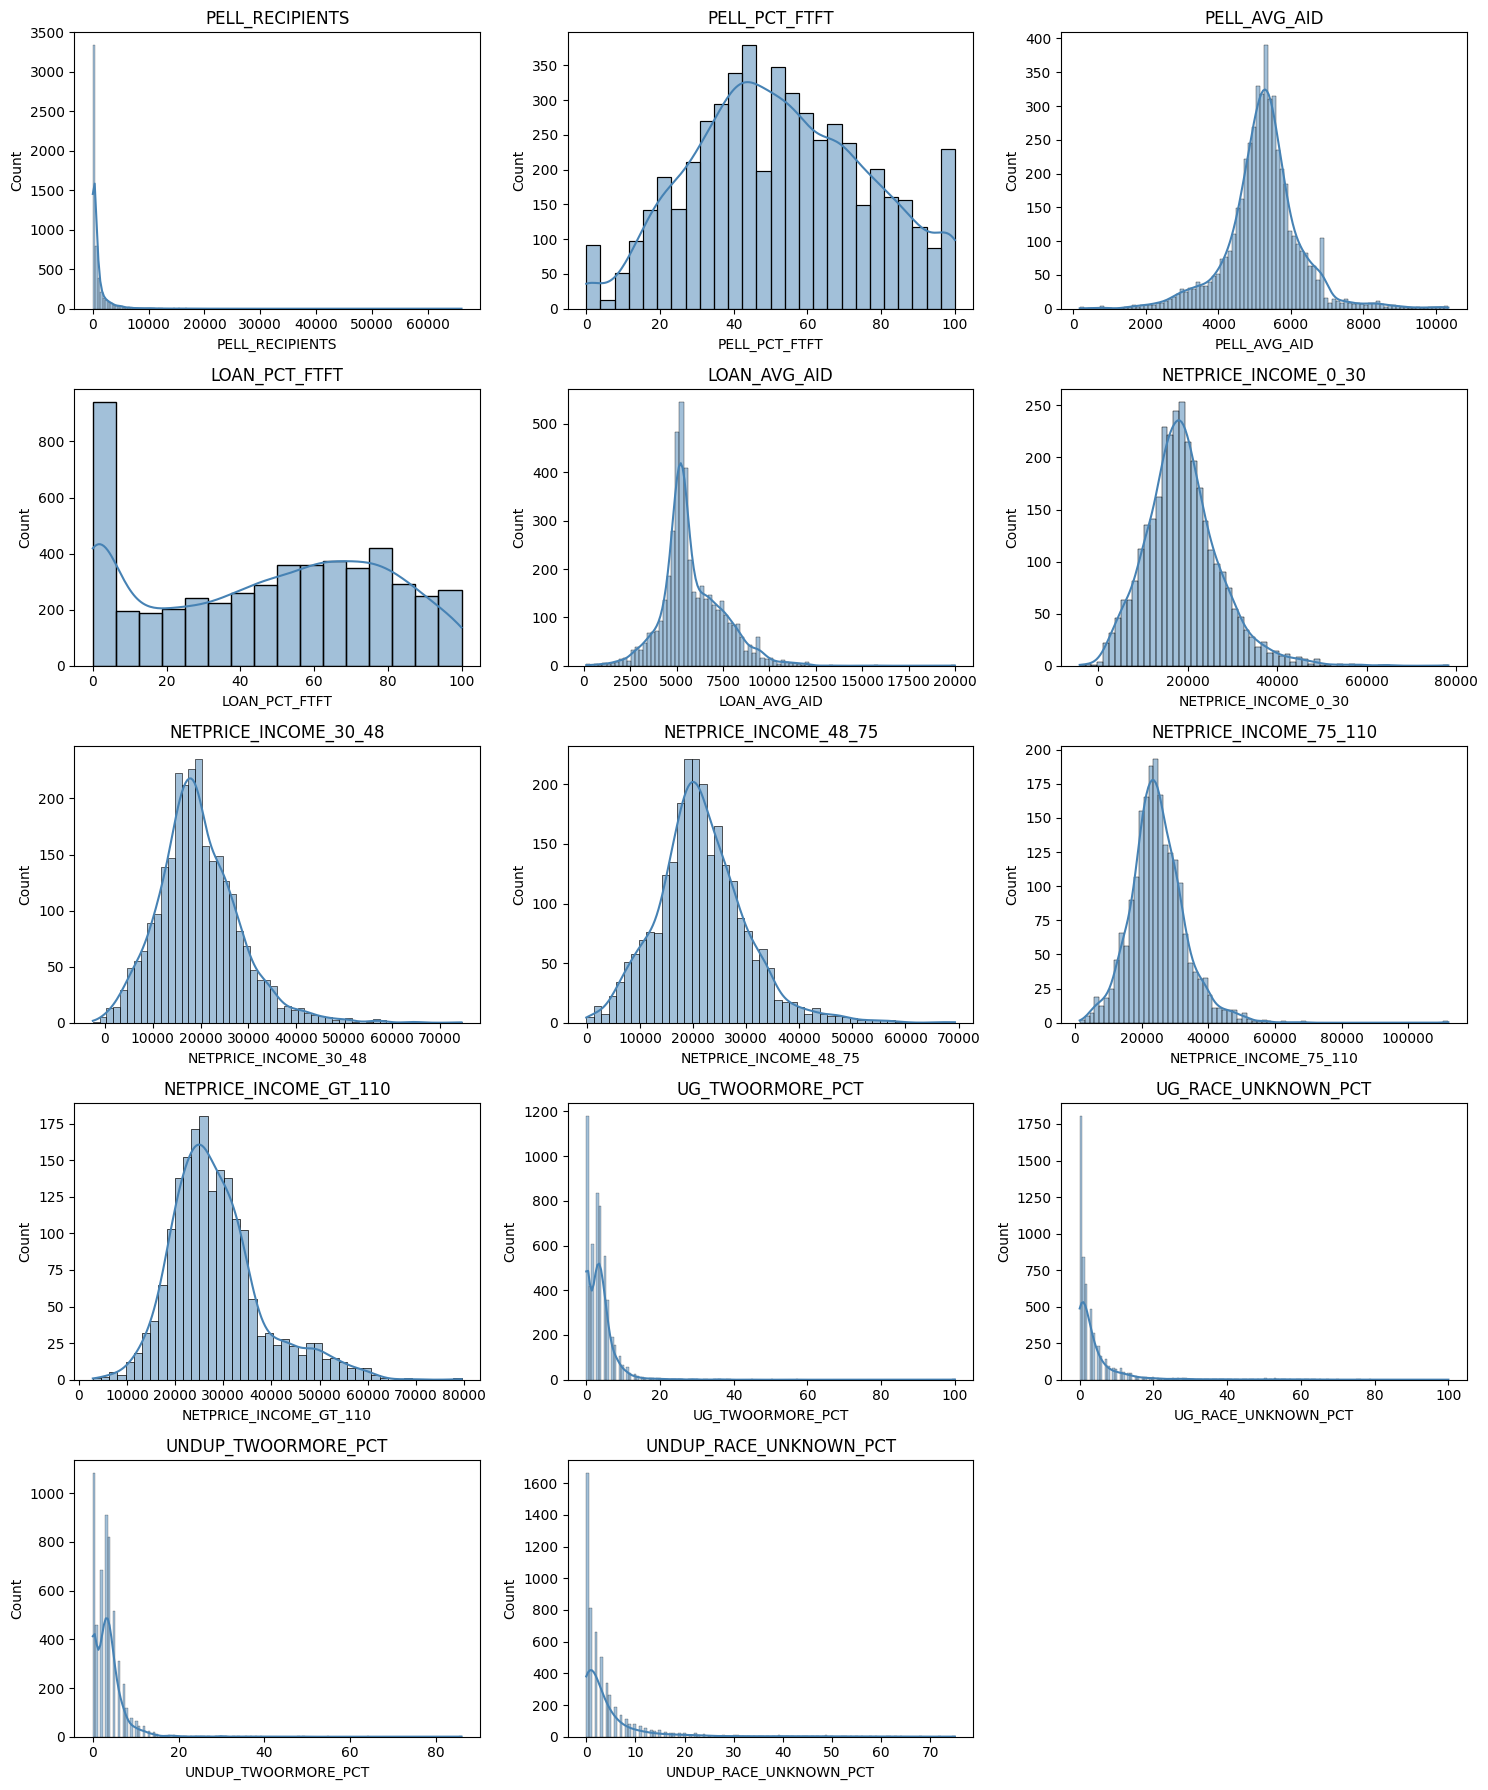

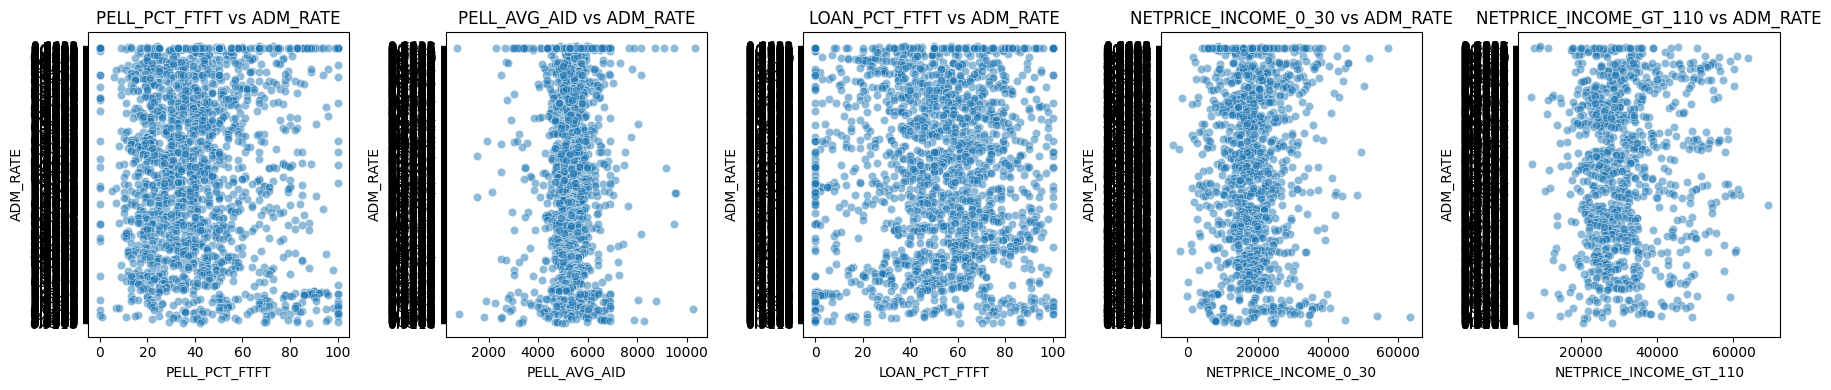

,CONTROL,AVG_PELL_PCT
0,1,47.826087
1,2,41.946724
2,3,65.257706


In [10]:
# Histograms for the new numeric IPEDS features
fig, axes = plt.subplots(5, 3, figsize=(15, 18))
axes = axes.flatten()
for idx, col in enumerate(ipeds_feature_cols):
    sns.histplot(df[col], kde=True, ax=axes[idx], color='steelblue')
    axes[idx].set_title(col)
for j in range(len(ipeds_feature_cols), len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

# Scatter relationships vs admission rate
focus_cols = ['PELL_PCT_FTFT', 'PELL_AVG_AID', 'LOAN_PCT_FTFT', 'NETPRICE_INCOME_0_30', 'NETPRICE_INCOME_GT_110']
fig, axes = plt.subplots(1, len(focus_cols), figsize=(18, 4))
for ax, col in zip(axes, focus_cols):
    sns.scatterplot(x=df[col], y=df['ADM_RATE'], ax=ax, alpha=0.5)
    ax.set_xlabel(col)
    ax.set_ylabel('ADM_RATE')
    ax.set_title(f'{col} vs ADM_RATE')
plt.tight_layout()
plt.show()

# Grouped summary: average Pell % by control type
pell_by_control = df.groupby('CONTROL')['PELL_PCT_FTFT'].mean().reset_index()
pell_by_control.columns = ['CONTROL', 'AVG_PELL_PCT']
pell_by_control


*Observation:* Public institutions (CONTROL=1) award Pell Grants to a higher share of full-time first-time students on average, while very high net-price brackets skew toward private not-for-profit schools. These insights will feed into the feature-selection step below.


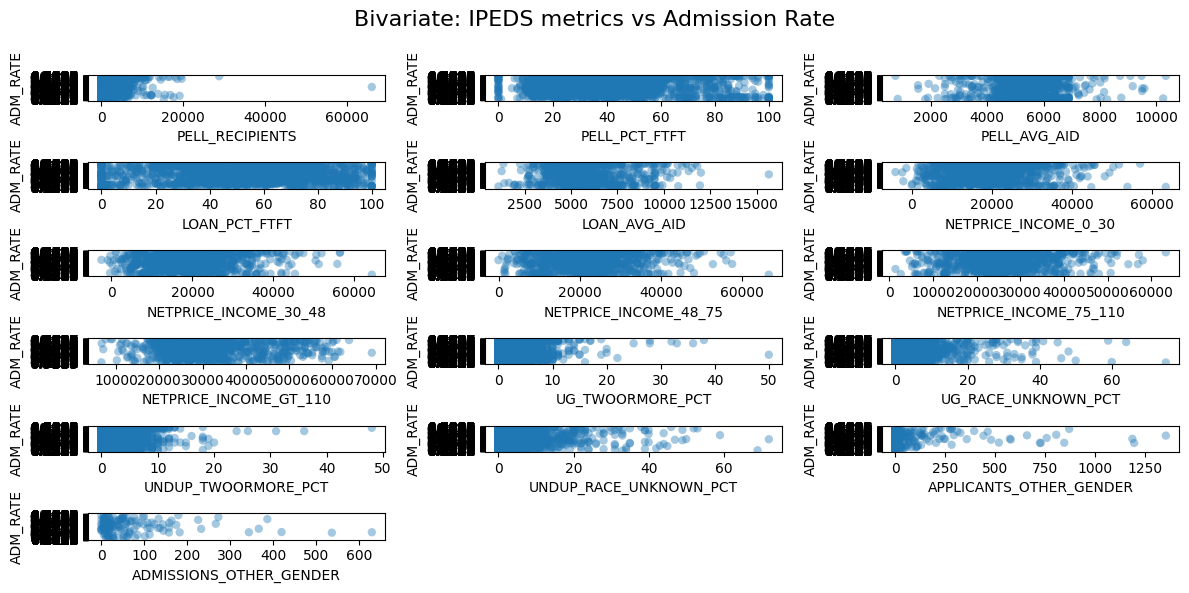

In [11]:
plt.figure(figsize=(12, 6))
for idx, col in enumerate(ipeds_focus_cols, start=1):
    plt.subplot(int(np.ceil(len(ipeds_focus_cols)/3)), 3, idx)
    sns.scatterplot(x=df[col], y=df['ADM_RATE'], alpha=0.4, edgecolor='none')
    plt.xlabel(col)
    plt.ylabel('ADM_RATE')
plt.suptitle('Bivariate: IPEDS metrics vs Admission Rate', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [12]:
ipeds_corr = df[ipeds_focus_cols + ['ADM_RATE']].corr()['ADM_RATE'].sort_values(ascending=False)
print("Correlation of IPEDS variables vs ADM_RATE:\n")
print(ipeds_corr.drop('ADM_RATE'))


Correlation of IPEDS variables vs ADM_RATE:

PELL_PCT_FTFT              0.243563
LOAN_PCT_FTFT              0.198509
NETPRICE_INCOME_30_48      0.185573
NETPRICE_INCOME_0_30       0.184833
LOAN_AVG_AID               0.142135
NETPRICE_INCOME_48_75      0.127465
UG_RACE_UNKNOWN_PCT        0.051156
UNDUP_RACE_UNKNOWN_PCT     0.030532
NETPRICE_INCOME_75_110     0.025004
ADMISSIONS_OTHER_GENDER    0.024004
PELL_RECIPIENTS            0.007235
PELL_AVG_AID              -0.022610
UG_TWOORMORE_PCT          -0.142516
UNDUP_TWOORMORE_PCT       -0.159649
APPLICANTS_OTHER_GENDER   -0.375359
NETPRICE_INCOME_GT_110    -0.434092
Name: ADM_RATE, dtype: float64


### Pell, TEACH, and IASG Insights (Guideline Step 1)
The stitched Pell grant file adds institution-level federal aid intensity. We inspect missingness and distributions to confirm signal before using these fields in feature selection.


Missingness (% of institutions) for Pell/TEACH/IASG fields:

IASG_DISBURSEMENTS_TOTAL     98.6
TEACH_DISBURSEMENTS_TOTAL    88.8
PELL_DISBURSEMENTS_TOTAL     25.7
PELL_RECIPIENTS_TOTAL        25.7
TEACH_RECIPIENTS_TOTAL       25.7
IASG_RECIPIENTS_TOTAL        25.7
dtype: float64


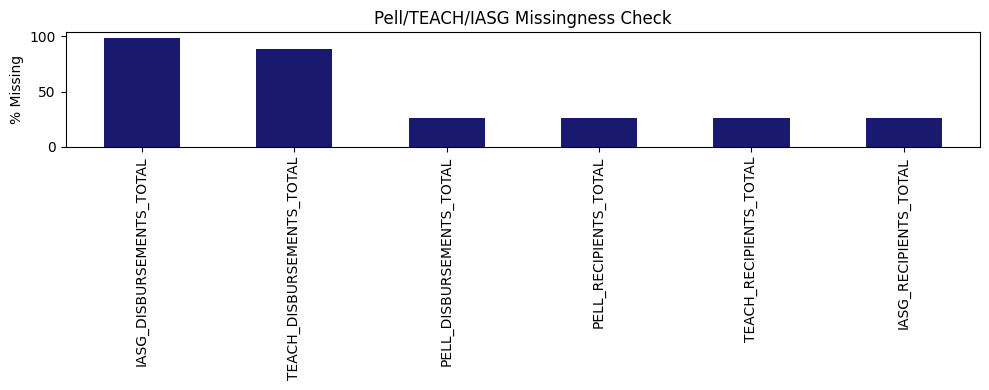

,mean,std,min,max
PELL_RECIPIENTS_TOTAL,2.542999e+03,6.584692e+03,0.0,214398.0
PELL_DISBURSEMENTS_TOTAL,5.817034e+06,1.377763e+07,1479.0,258480070.0
TEACH_RECIPIENTS_TOTAL,8.305294e+00,8.212539e+01,0.0,4703.0
TEACH_DISBURSEMENTS_TOTAL,9.499188e+04,4.380989e+05,927.0,10725148.0
IASG_RECIPIENTS_TOTAL,4.289600e-02,3.860823e-01,0.0,13.0
IASG_DISBURSEMENTS_TOTAL,7.746160e+03,5.090621e+03,1167.0,39817.0


In [13]:
pell_feature_cols = [
    "PELL_RECIPIENTS_TOTAL", "PELL_DISBURSEMENTS_TOTAL",
    "TEACH_RECIPIENTS_TOTAL", "TEACH_DISBURSEMENTS_TOTAL",
    "IASG_RECIPIENTS_TOTAL", "IASG_DISBURSEMENTS_TOTAL"
]
pell_available = [col for col in pell_feature_cols if col in df.columns]

print("Missingness (% of institutions) for Pell/TEACH/IASG fields:\n")
pell_missing = df[pell_available].isna().mean().round(3) * 100
print(pell_missing.sort_values(ascending=False))

plt.figure(figsize=(10, 4))
pell_missing.sort_values(ascending=False).plot(kind='bar', color='midnightblue')
plt.ylabel('% Missing')
plt.title('Pell/TEACH/IASG Missingness Check')
plt.tight_layout()
plt.show()

pell_summary = df[pell_available].describe().T
pell_summary[["mean", "std", "min", "max"]]


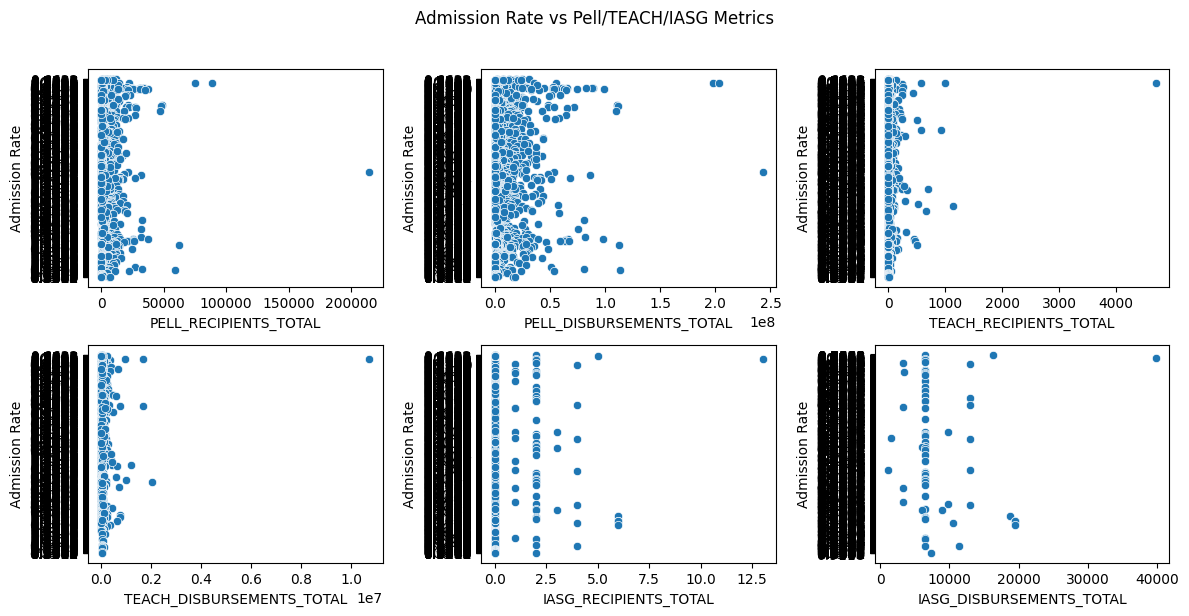

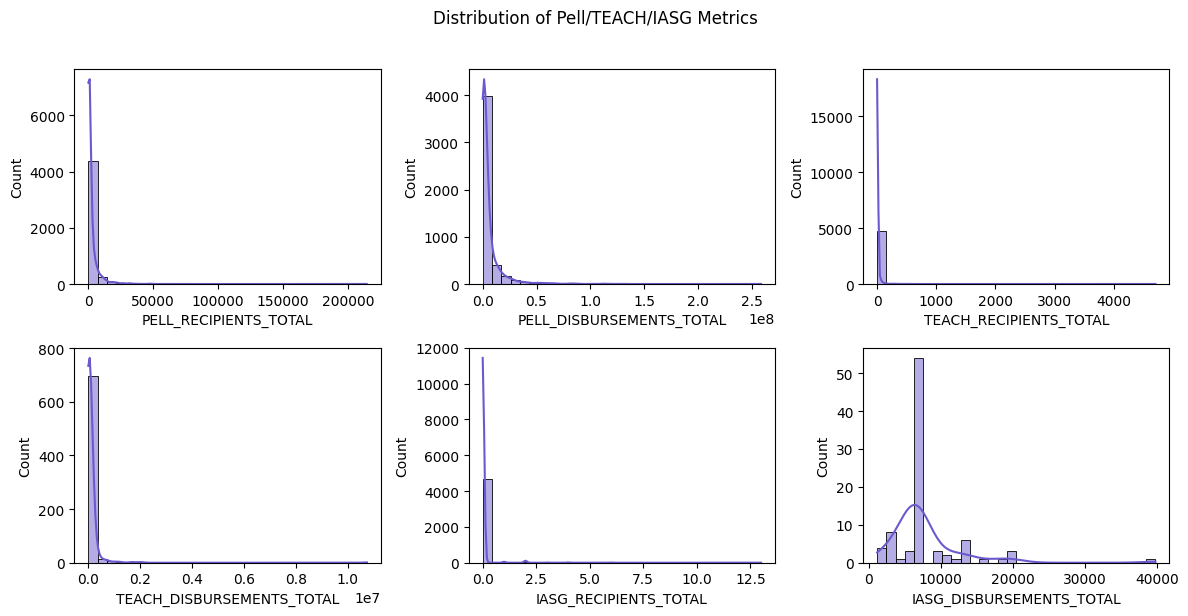

In [14]:
plt.figure(figsize=(12, 6))
for idx, col in enumerate(pell_available, start=1):
    plt.subplot(2, 3, idx)
    sns.scatterplot(x=df[col], y=df['ADM_RATE'])
    plt.xlabel(col)
    plt.ylabel('Admission Rate')
plt.suptitle('Admission Rate vs Pell/TEACH/IASG Metrics', y=1.02)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for idx, col in enumerate(pell_available, start=1):
    plt.subplot(2, 3, idx)
    sns.histplot(df[col], kde=True, bins=30, color='slateblue')
    plt.xlabel(col)
plt.suptitle('Distribution of Pell/TEACH/IASG Metrics', y=1.02)
plt.tight_layout()
plt.show()


### Direct Loan Program View (Guideline Step 1)
Direct Loan aggregates highlight the scale of federal borrowing by program. These features supply financial context beyond tuition and debt medians.


Missingness (% of institutions) for Direct Loan fields:

DL_GRAD_PLUS_DISBURSEMENTS      76.8
DL_GRAD_DISBURSEMENTS           71.8
DL_PARENT_PLUS_DISBURSEMENTS    45.9
DL_SUB_DISBURSEMENTS            34.1
DL_UNDERGRAD_DISBURSEMENTS      33.7
DL_SUB_RECIPIENTS               30.4
DL_UNDERGRAD_RECIPIENTS         30.4
DL_PARENT_PLUS_RECIPIENTS       30.4
DL_GRAD_RECIPIENTS              30.4
DL_GRAD_PLUS_RECIPIENTS         30.4
DL_TOTAL_RECIPIENTS             30.4
DL_TOTAL_DISBURSEMENTS          30.4
dtype: float64


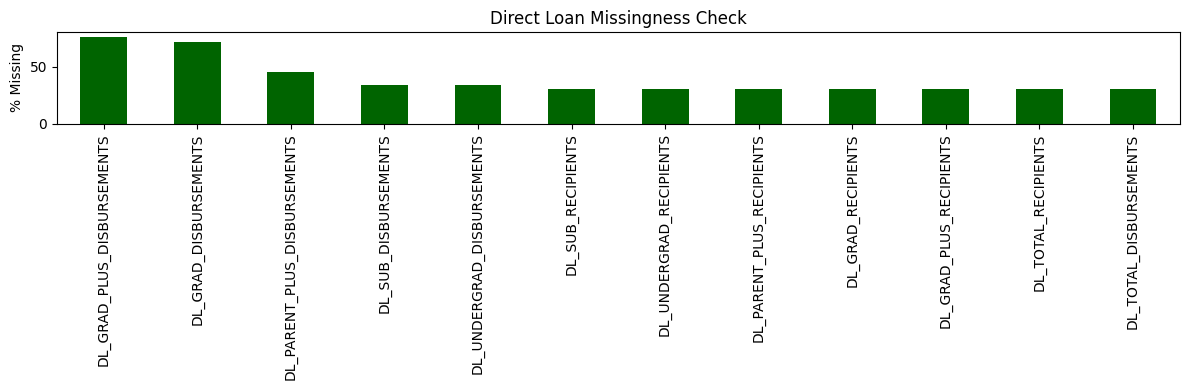

,mean,std,min,max
DL_SUB_RECIPIENTS,1.049860e+03,3.269626e+03,0.0,120045.0
DL_SUB_DISBURSEMENTS,3.744910e+06,1.059371e+07,1750.0,332897187.0
DL_UNDERGRAD_RECIPIENTS,1.086349e+03,3.230134e+03,0.0,107953.0
DL_UNDERGRAD_DISBURSEMENTS,4.280593e+06,1.301390e+07,297.0,389607419.0
DL_PARENT_PLUS_RECIPIENTS,1.570221e+02,4.532736e+02,0.0,8349.0
DL_PARENT_PLUS_DISBURSEMENTS,3.324731e+06,9.747970e+06,517.0,164746324.0
DL_GRAD_RECIPIENTS,3.720038e+02,1.536559e+03,0.0,38294.0
DL_GRAD_DISBURSEMENTS,1.447424e+07,3.223593e+07,1051.0,533953304.0
DL_GRAD_PLUS_RECIPIENTS,1.304763e+02,5.466997e+02,0.0,13762.0
DL_GRAD_PLUS_DISBURSEMENTS,8.315520e+06,2.233827e+07,305.0,313549240.0


In [15]:
loan_feature_cols = [
    "DL_SUB_RECIPIENTS", "DL_SUB_DISBURSEMENTS",
    "DL_UNDERGRAD_RECIPIENTS", "DL_UNDERGRAD_DISBURSEMENTS",
    "DL_PARENT_PLUS_RECIPIENTS", "DL_PARENT_PLUS_DISBURSEMENTS",
    "DL_GRAD_RECIPIENTS", "DL_GRAD_DISBURSEMENTS",
    "DL_GRAD_PLUS_RECIPIENTS", "DL_GRAD_PLUS_DISBURSEMENTS",
    "DL_TOTAL_RECIPIENTS", "DL_TOTAL_DISBURSEMENTS"
]
loan_available = [col for col in loan_feature_cols if col in df.columns]

loan_missing = df[loan_available].isna().mean().round(3) * 100
print("Missingness (% of institutions) for Direct Loan fields:\n")
print(loan_missing.sort_values(ascending=False))

plt.figure(figsize=(12, 4))
loan_missing.sort_values(ascending=False).plot(kind='bar', color='darkgreen')
plt.ylabel('% Missing')
plt.title('Direct Loan Missingness Check')
plt.tight_layout()
plt.show()

loan_summary = df[loan_available].describe().T
loan_summary[["mean", "std", "min", "max"]]


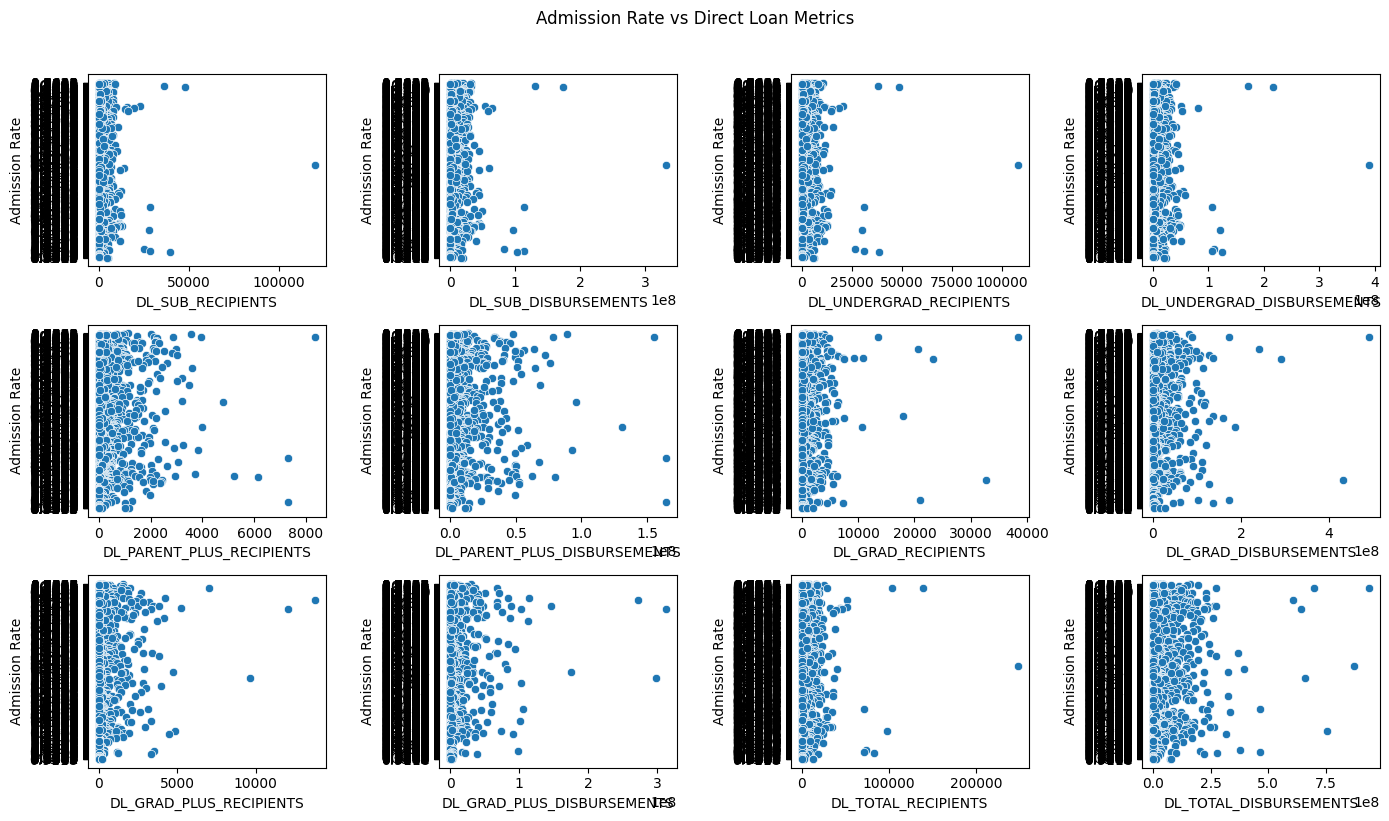

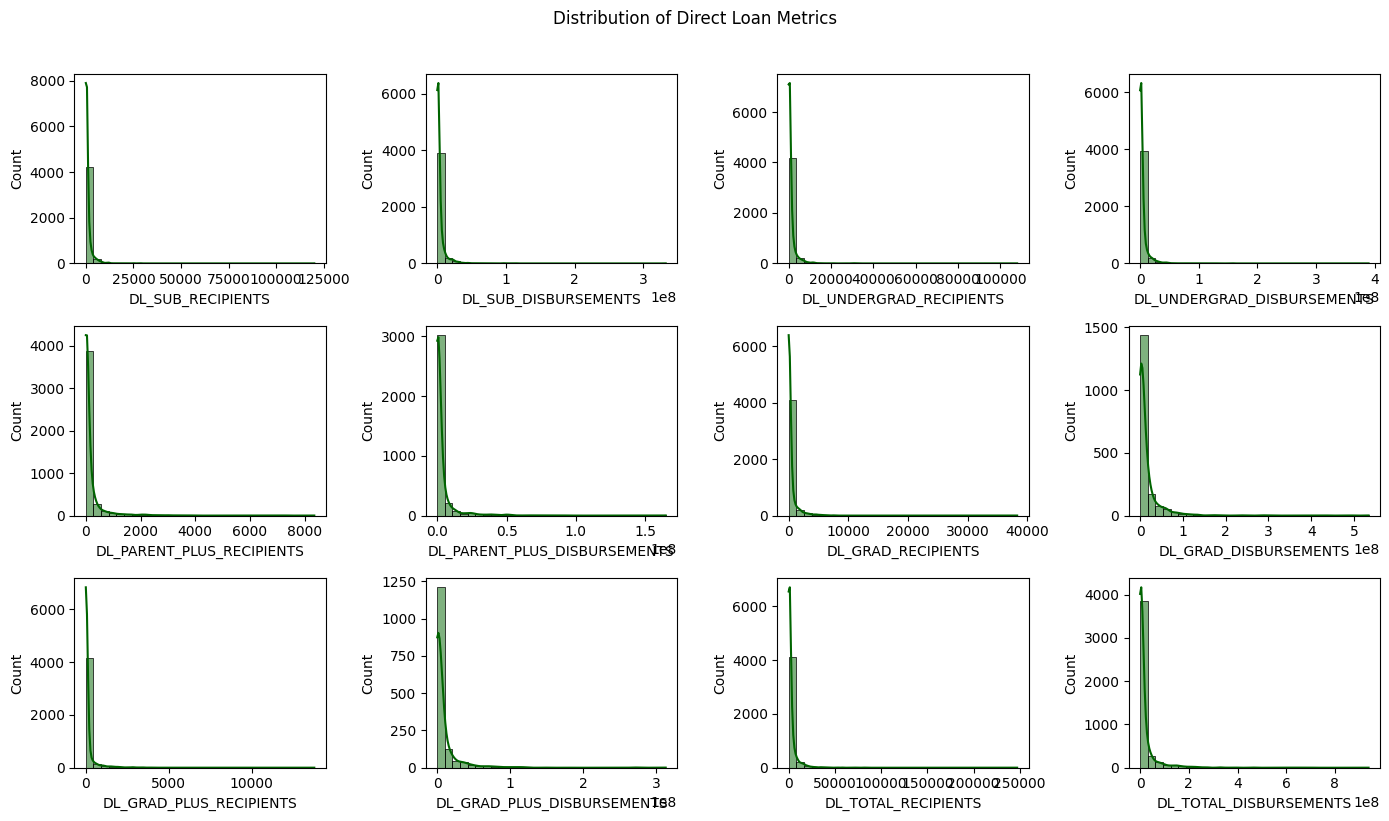

In [16]:
plt.figure(figsize=(14, 8))
for idx, col in enumerate(loan_available, start=1):
    plt.subplot(3, 4, idx)
    sns.scatterplot(x=df[col], y=df['ADM_RATE'])
    plt.xlabel(col)
    plt.ylabel('Admission Rate')
plt.suptitle('Admission Rate vs Direct Loan Metrics', y=1.02)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
for idx, col in enumerate(loan_available, start=1):
    plt.subplot(3, 4, idx)
    sns.histplot(df[col], bins=30, kde=True, color='darkgreen')
    plt.xlabel(col)
plt.suptitle('Distribution of Direct Loan Metrics', y=1.02)
plt.tight_layout()
plt.show()


In [17]:
# Load the College Scorecard data dictionary (df already loaded above)
dictionary = pd.read_excel(
    "../Data_Assets/collegescorecarddatadictionary.xlsx",
    sheet_name="Institution_Data_Dictionary"
)

# Preview structure
print(dictionary.columns)
dictionary.head(3251)

Index(['NAME OF DATA ELEMENT', 'dev-category', 'developer-friendly name', 'API data type', 'INDEX', 'VARIABLE NAME',
       'VALUE', 'LABEL', 'SOURCE', 'SHOWN/USE ON SITE', 'NOTES'],
      dtype='object')


,NAME OF DATA ELEMENT,dev-category,developer-friendly name,API data type,INDEX,VARIABLE NAME,VALUE,LABEL,SOURCE,SHOWN/USE ON SITE,NOTES
0,Unit ID for institution,root,id,integer,NaN,UNITID,NaN,NaN,IPEDS,Yes,NaN
1,8-digit OPE ID for institution,root,ope8_id,string,varchar(10),OPEID,NaN,NaN,IPEDS,Yes,NaN
2,6-digit OPE ID for institution,root,ope6_id,string,varchar(10),OPEID6,NaN,NaN,IPEDS,Yes,NaN
3,Institution name,school,name,autocomplete,fulltext,INSTNM,NaN,NaN,IPEDS,Yes,NaN
4,City,school,city,autocomplete,varchar(200),CITY,NaN,NaN,IPEDS,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3246,Median earnings of students working and not en...,earnings,10_yrs_after_entry.median_earnings.highest_ter...,integer,NaN,MD_EARN_WNE_INC3_P10,NaN,NaN,Treasury,NaN,NaN
3247,Median earnings of independent students workin...,earnings,10_yrs_after_entry.median_earnings.independent...,integer,NaN,MD_EARN_WNE_INDEP1_P10,NaN,NaN,Treasury,NaN,NaN
3248,Median earnings of dependent students working ...,earnings,10_yrs_after_entry.median_earnings.dependent_s...,integer,NaN,MD_EARN_WNE_INDEP0_P10,NaN,NaN,Treasury,NaN,NaN
3249,Median earnings of non-male students working a...,earnings,10_yrs_after_entry.median_earnings.non_male_st...,integer,NaN,MD_EARN_WNE_MALE0_P10,NaN,NaN,Treasury,NaN,NaN


In [18]:
# Keep only relevant columns for clarity
dictionary_clean = dictionary[['VARIABLE NAME', 'NAME OF DATA ELEMENT', 'API data type']].dropna(subset=['VARIABLE NAME'])

# Rename for clarity
dictionary_clean.columns = ['VARIABLE_NAME', 'DESCRIPTION', 'EXPECTED_TYPE']

# Preview
dictionary_clean.head(3251)


,VARIABLE_NAME,DESCRIPTION,EXPECTED_TYPE
0,UNITID,Unit ID for institution,integer
1,OPEID,8-digit OPE ID for institution,string
2,OPEID6,6-digit OPE ID for institution,string
3,INSTNM,Institution name,autocomplete
4,CITY,City,autocomplete
...,...,...,...
3246,MD_EARN_WNE_INC3_P10,Median earnings of students working and not en...,integer
3247,MD_EARN_WNE_INDEP1_P10,Median earnings of independent students workin...,integer
3248,MD_EARN_WNE_INDEP0_P10,Median earnings of dependent students working ...,integer
3249,MD_EARN_WNE_MALE0_P10,Median earnings of non-male students working a...,integer


In [19]:
dictionary_clean = dictionary[['VARIABLE NAME', 'API data type']].dropna(subset=['VARIABLE NAME'])
dictionary_clean.columns = ['VARIABLE_NAME', 'EXPECTED_TYPE']

# Extract dataframe schema
dtype_summary = df.dtypes.reset_index()
dtype_summary.columns = ['VARIABLE_NAME', 'DATA_TYPE']

# Merge with dictionary
schema_merged = dtype_summary.merge(dictionary_clean, on='VARIABLE_NAME', how='left')
schema_merged.head(10)


,VARIABLE_NAME,DATA_TYPE,EXPECTED_TYPE
0,UNITID,object,integer
1,OPEID,object,string
2,OPEID6,object,string
3,INSTNM,object,autocomplete
4,CITY,object,autocomplete
5,STABBR,object,string
6,ZIP,object,string
7,ACCREDAGENCY,object,string
8,INSTURL,object,string
9,NPCURL,object,string


In [20]:
# Build conversion map
type_map = {
    'integer': 'Int64',      # pandas nullable integer
    'float': 'float64',
    'string': 'string',
    'autocomplete': 'string'
}

# Generate per-column conversion mapping
conversion_dict = {}
for _, row in dictionary_clean.iterrows():
    col = row['VARIABLE_NAME']
    typ = row['EXPECTED_TYPE']
    if typ in type_map and col in df.columns:
        conversion_dict[col] = type_map[typ]

conversion_dict



{'UNITID': 'Int64',
 'OPEID': 'string',
 'OPEID6': 'string',
 'INSTNM': 'string',
 'CITY': 'string',
 'STABBR': 'string',
 'ZIP': 'string',
 'ACCREDAGENCY': 'string',
 'INSTURL': 'string',
 'NPCURL': 'string',
 'SCH_DEG': 'Int64',
 'HCM2': 'Int64',
 'MAIN': 'Int64',
 'NUMBRANCH': 'Int64',
 'PREDDEG': 'Int64',
 'HIGHDEG': 'Int64',
 'CONTROL': 'Int64',
 'ST_FIPS': 'Int64',
 'REGION': 'Int64',
 'LOCALE': 'Int64',
 'LOCALE2': 'Int64',
 'LATITUDE': 'float64',
 'LONGITUDE': 'float64',
 'CCBASIC': 'Int64',
 'CCUGPROF': 'Int64',
 'CCSIZSET': 'Int64',
 'HBCU': 'Int64',
 'PBI': 'Int64',
 'ANNHI': 'Int64',
 'TRIBAL': 'Int64',
 'AANAPII': 'Int64',
 'HSI': 'Int64',
 'NANTI': 'Int64',
 'MENONLY': 'Int64',
 'WOMENONLY': 'Int64',
 'RELAFFIL': 'Int64',
 'ADM_RATE': 'float64',
 'ADM_RATE_ALL': 'float64',
 'SATVR25': 'float64',
 'SATVR75': 'float64',
 'SATMT25': 'float64',
 'SATMT75': 'float64',
 'SATWR25': 'float64',
 'SATWR75': 'float64',
 'SATVRMID': 'float64',
 'SATMTMID': 'float64',
 'SATWRMID': 'fl

In [21]:


conversion_dict = {}
for _, row in dictionary_clean.iterrows():
    col = row['VARIABLE_NAME']
    typ = row['EXPECTED_TYPE']
    if typ in type_map and col in df.columns:
        conversion_dict[col] = type_map[typ]

print(f"✅ Found {len(conversion_dict)} columns to convert based on dictionary.\n")

# -------------------------------
# 4️⃣ Clean invalid / non-numeric text
# -------------------------------
invalid_values = ["PrivacySuppressed", "NULL", "NaN", "nan", ".", ""]
df = df.replace(invalid_values, pd.NA)

# -------------------------------
# 5️⃣ Safe conversion loop
# -------------------------------
failed_columns = []

print("🔄 Converting columns...")
for col, dtype in conversion_dict.items():
    try:
        df[col] = df[col].astype(dtype)
    except Exception as e:
        failed_columns.append(col)
        print(f"⚠️ Skipped '{col}' — could not convert to {dtype}. Error: {e}")

# -------------------------------
# 6️⃣ Report conversion results
# -------------------------------
print("\n✅ Conversion complete!")
print(f"🔹 Successfully converted: {len(conversion_dict) - len(failed_columns)} columns")
print(f"🔸 Failed to convert: {len(failed_columns)} columns\n")

if failed_columns:
    print("❌ Columns that could not be converted:")
    print(failed_columns)

# -------------------------------
# 7️⃣ Before/after comparison
# -------------------------------
print("\n📊 Updated DataFrame info:")
df.info()


✅ Found 2922 columns to convert based on dictionary.

🔄 Converting columns...
⚠️ Skipped 'DEATH_YR2_RT' — could not convert to float64. Error: could not convert string to float: 'PS'
⚠️ Skipped 'COMP_ORIG_YR2_RT' — could not convert to float64. Error: could not convert string to float: 'PS'
⚠️ Skipped 'COMP_4YR_TRANS_YR2_RT' — could not convert to float64. Error: could not convert string to float: 'PS'
⚠️ Skipped 'COMP_2YR_TRANS_YR2_RT' — could not convert to float64. Error: could not convert string to float: 'PS'
⚠️ Skipped 'WDRAW_ORIG_YR2_RT' — could not convert to float64. Error: could not convert string to float: 'PS'
⚠️ Skipped 'WDRAW_4YR_TRANS_YR2_RT' — could not convert to float64. Error: could not convert string to float: 'PS'
⚠️ Skipped 'WDRAW_2YR_TRANS_YR2_RT' — could not convert to float64. Error: could not convert string to float: 'PS'
⚠️ Skipped 'ENRL_ORIG_YR2_RT' — could not convert to float64. Error: could not convert string to float: 'PS'
⚠️ Skipped 'ENRL_4YR_TRANS_YR2_

🔍 Missingness summary (top 20 columns):

UG_AIANOLD         100.0
UG_API             100.0
UGDS_API           100.0
UGDS_BLACKNH       100.0
D150_4_API         100.0
D150_L4_AIANOLD    100.0
D150_L4_API        100.0
D150_4_AIANOLD     100.0
UG_BLACKNH         100.0
UG_WHITENH         100.0
UGDS_HISPOLD       100.0
UG_UNKN            100.0
UGDS_AIANOLD       100.0
NPT4_OTHER         100.0
UGDS_WHITENH       100.0
PPTUG_EF2          100.0
D150_4_BLACKNH     100.0
D150_4_HISPOLD     100.0
D150_L4_BLACKNH    100.0
NPT44_PROG         100.0
dtype: float64


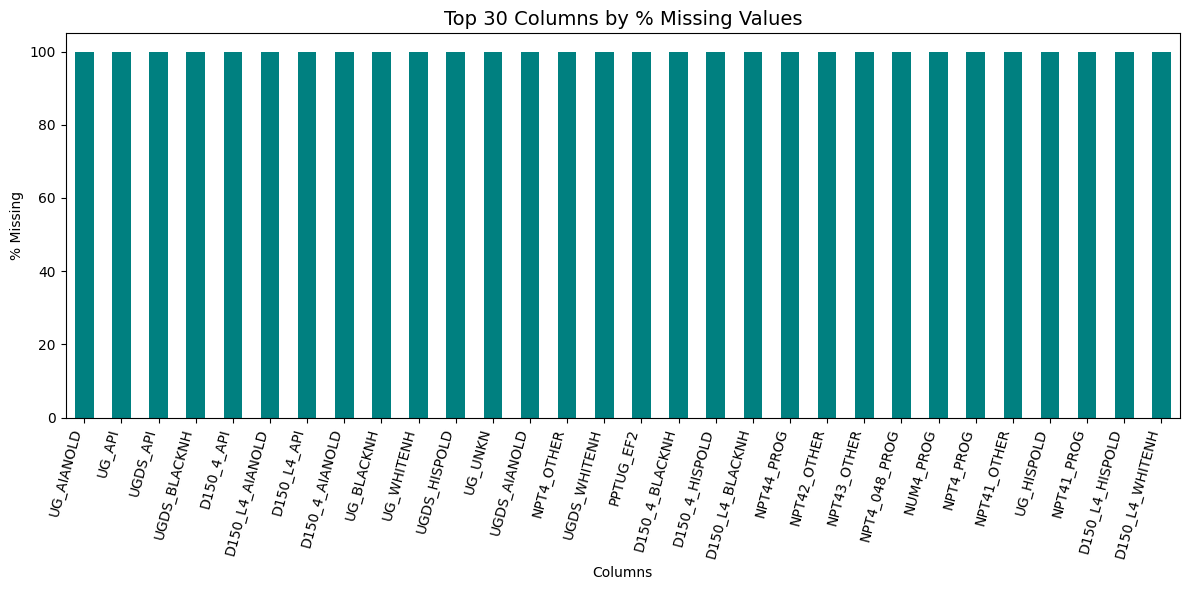

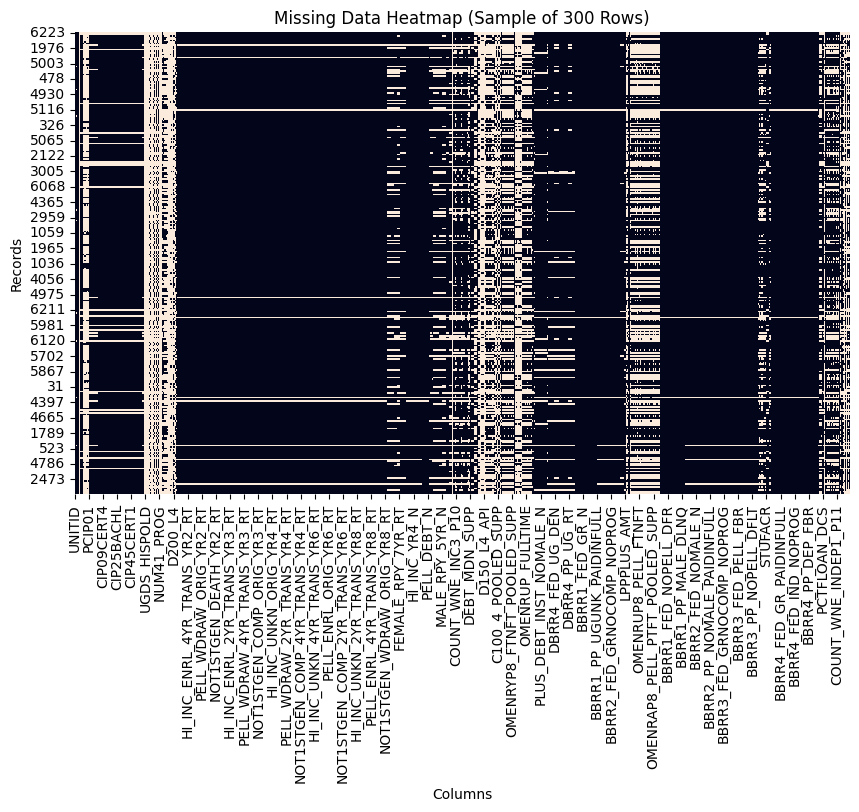

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1️⃣ Missingness by column (%)
# -------------------------------
missing_percent = df.isna().mean().round(3) * 100
missing_percent = missing_percent.sort_values(ascending=False)

print("🔍 Missingness summary (top 20 columns):\n")
print(missing_percent.head(20))

# -------------------------------
# 2️⃣ Bar chart of missingness
# -------------------------------
plt.figure(figsize=(12, 6))
missing_percent.head(30).plot(kind='bar', color='teal')
plt.title("Top 30 Columns by % Missing Values", fontsize=14)
plt.ylabel("% Missing")
plt.xlabel("Columns")
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

# -------------------------------
# 3️⃣ Heatmap of missingness (sample)
# -------------------------------
sample = df.sample(300)  # smaller subset to keep visualization fast
plt.figure(figsize=(10, 6))
sns.heatmap(sample.isna(), cbar=False)
plt.title("Missing Data Heatmap (Sample of 300 Rows)")
plt.xlabel("Columns")
plt.ylabel("Records")
plt.show()


In [23]:
import pandas as pd 


# -------------------------------
# 🧹 Drop empty/sparse columns
# -------------------------------
before_cols = df.shape[1]
df = df.dropna(axis=1, how='all')  # drop 100% missing
df = df.loc[:, df.isna().mean() < 0.9]  # drop >90% missing
after_cols = df.shape[1]

print(f"✅ Dropped {before_cols - after_cols} columns with extreme missingness.")
print("📊 New dataset shape:", df.shape)

# Re-check missing summary
missing_percent = df.isna().mean().round(3) * 100
print("\n🔍 Remaining Missingness (Top 10 columns):")
print(missing_percent.sort_values(ascending=False).head(10))


✅ Dropped 88 columns with extreme missingness.
📊 New dataset shape: (6429, 3261)

🔍 Remaining Missingness (Top 10 columns):
SATWR25                      89.0
SATWR75                      89.0
SATWRMID                     89.0
TEACH_DISBURSEMENTS_TOTAL    88.8
CIPTITLE5                    87.3
C150_L4_AIAN                 87.3
CIPTFBSANNUAL5               87.2
CIPTFBS5                     87.2
MTHCMP5                      87.1
CIPCODE5                     87.1
dtype: float64


In [24]:
import pandas as pd 
# -------------------------------
# 🔍 Duplicates & Numeric Sanity Checks
# -------------------------------

# 1️⃣ Check for duplicate rows
dup_count = df.duplicated().sum()
print(f"🧬 Duplicate rows found: {dup_count}")

if dup_count > 0:
    df = df.drop_duplicates()
    print(f"✅ Duplicates removed. New shape: {df.shape}")
else:
    print("✅ No duplicate rows found.")

# 2️⃣ Quick numeric summary to flag impossible values
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
summary = df[num_cols].describe().T

# Flag numeric anomalies
possible_issues = summary[(summary["min"] < 0) | (summary["max"] > 1e7)]
print("\n⚠️ Possible numeric anomalies (min < 0 or max > 10 M):")
print(possible_issues[["min", "max"]])


🧬 Duplicate rows found: 0
✅ No duplicate rows found.

⚠️ Possible numeric anomalies (min < 0 or max > 10 M):
                                     min          max
UNITID                          100654.0   49664501.0
LOCALE                              -3.0         43.0
LATITUDE                      -14.322636    71.324702
LONGITUDE                    -170.742774   171.378129
CCBASIC                             -2.0         33.0
CCUGPROF                            -2.0         15.0
CCSIZSET                            -2.0         18.0
NPT4_PUB                         -3220.0      40172.0
NPT41_PUB                        -6023.0      38184.0
NPT42_PUB                        -4533.0      40729.0
NPT43_PUB                        -2209.0      41521.0
NPT45_PUB                        -3153.0      37946.0
NPT41_PRIV                       -4129.0      78201.0
NPT42_PRIV                       -2483.0      74499.0
NPT43_PRIV                        -123.0      69323.0
NPT4_048_PUB               

### Step 2 — Reduce to ≤20 Features
We filter to interpretable, low-collinearity predictors (Scorecard + IPEDS + Pell + Direct Loan) that map back to the guideline’s feature reduction requirement.


In [25]:
# -------------------------------
# 🎯 Target Definition
# -------------------------------

# Target variable (y)
target_col = "ADM_RATE"

if target_col in df.columns:
    y = pd.to_numeric(df[target_col], errors="coerce")
    print(f"✅ Target variable '{target_col}' successfully loaded with {y.notna().sum()} valid entries.")
else:
    raise ValueError("❌ 'ADM_RATE' not found in dataset!")

# Selected predictors (X)
selected_features = [
    'SAT_AVG', 'COSTT4_A', 'PCTPELL', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP',
    'CONTROL', 'HIGHDEG', 'REGION', 'DEBT_MDN',
    'PELL_PCT_FTFT', 'LOAN_PCT_FTFT',
    'NETPRICE_INCOME_0_30', 'NETPRICE_INCOME_GT_110', 'UG_TWOORMORE_PCT',
    'PELL_RECIPIENTS_TOTAL', 'PELL_DISBURSEMENTS_TOTAL',
    'DL_TOTAL_RECIPIENTS', 'DL_TOTAL_DISBURSEMENTS', 'DL_PARENT_PLUS_DISBURSEMENTS'
]

# Convert selected features to numeric
X = df[selected_features].apply(pd.to_numeric, errors='coerce')

print(f"\n📊 Feature matrix shape: {X.shape}")
print(X.head())


✅ Target variable 'ADM_RATE' successfully loaded with 1946 valid entries.

📊 Feature matrix shape: (6429, 20)
   SAT_AVG  COSTT4_A  PCTPELL  UGDS_WHITE  UGDS_BLACK  UGDS_HISP  CONTROL  HIGHDEG  REGION  DEBT_MDN  PELL_PCT_FTFT  \
0    947.0     23751   0.6441      0.0180      0.9043     0.0150        1        4       5   16600.0           67.0   
1   1251.0     27826   0.3318      0.4832      0.2657     0.0776        1        4       5   15832.0           41.0   
2      NaN      <NA>   0.6842      0.2788      0.6681     0.0310        2        4       5   13385.0            NaN   
3   1321.0     27098   0.2250      0.6940      0.0907     0.0719        1        4       5   13905.0           24.0   
4    977.0     22028   0.7203      0.0223      0.9082     0.0111        1        4       5   17500.0           73.0   

   LOAN_PCT_FTFT  NETPRICE_INCOME_0_30  NETPRICE_INCOME_GT_110  UG_TWOORMORE_PCT  PELL_RECIPIENTS_TOTAL  \
0           57.0                   NaN                     NaN      

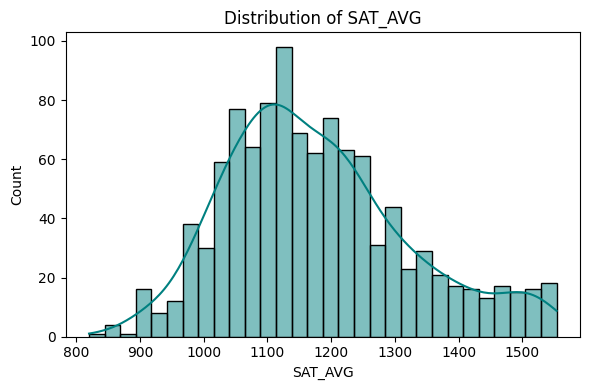

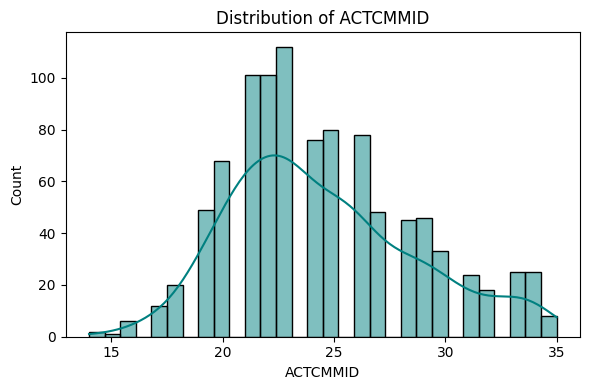

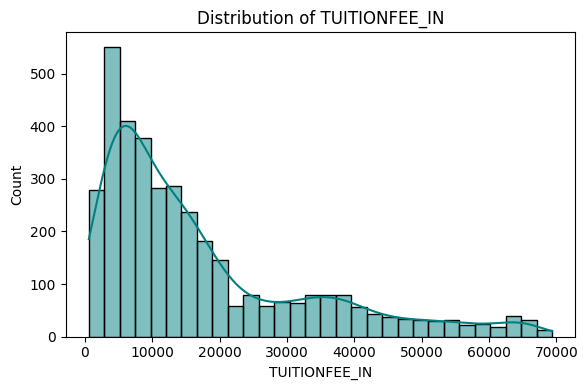

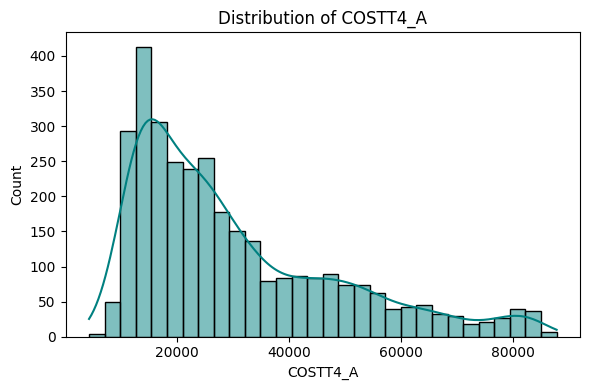

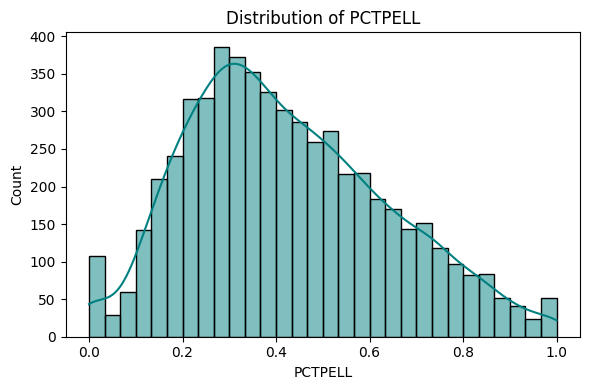

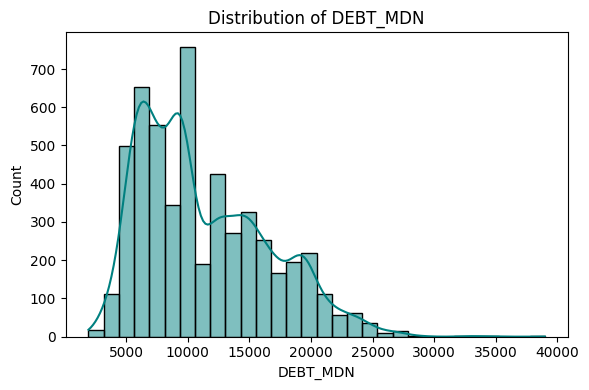

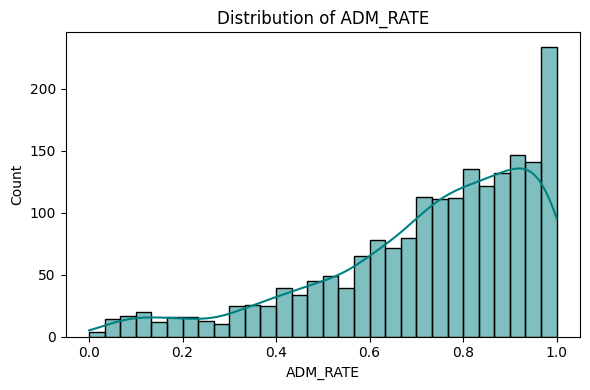

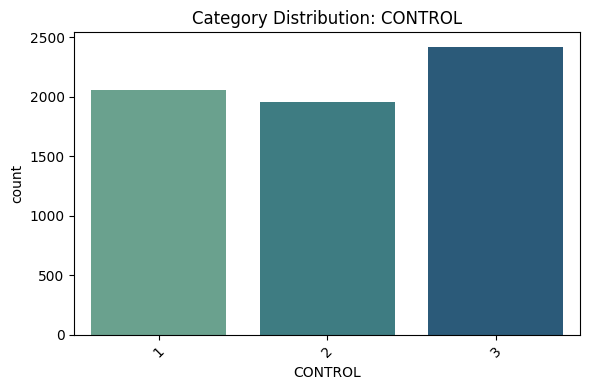

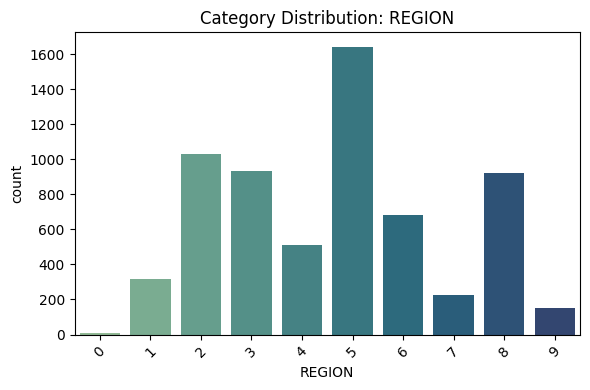

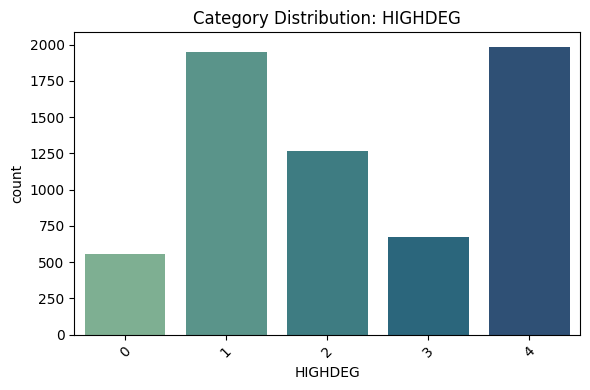

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 📈 Univariate Analysis
# -------------------------------

numeric_cols = ['SAT_AVG', 'ACTCMMID', 'TUITIONFEE_IN', 'COSTT4_A', 'PCTPELL', 'DEBT_MDN', 'ADM_RATE']
categorical_cols = ['CONTROL', 'REGION', 'HIGHDEG']

# Numeric variables — histograms
for col in numeric_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(pd.to_numeric(df[col], errors='coerce'), bins=30, kde=True, color='teal')
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

# Categorical variables — bar charts
for col in categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(x=df[col], palette='crest')
        plt.title(f"Category Distribution: {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


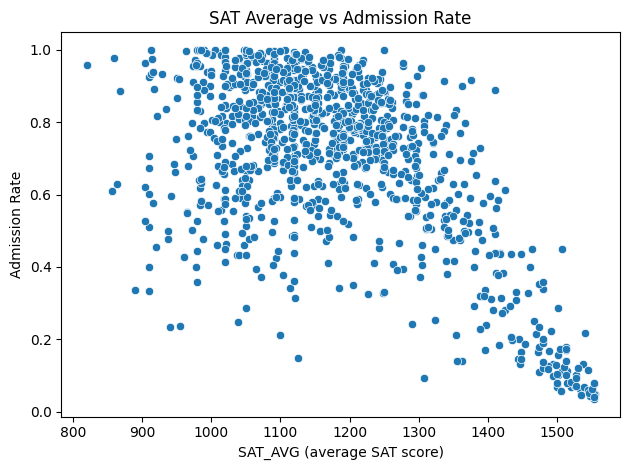

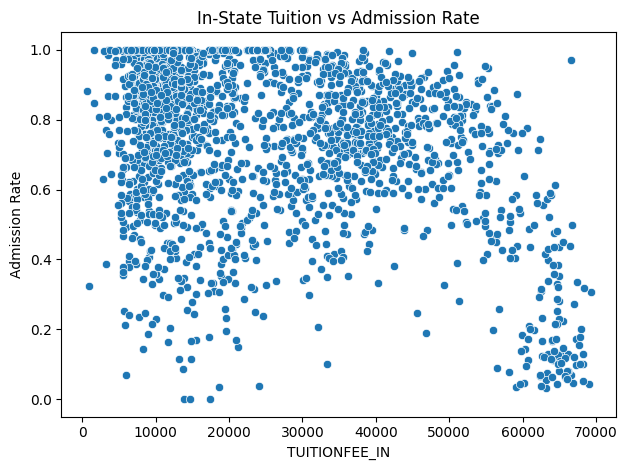

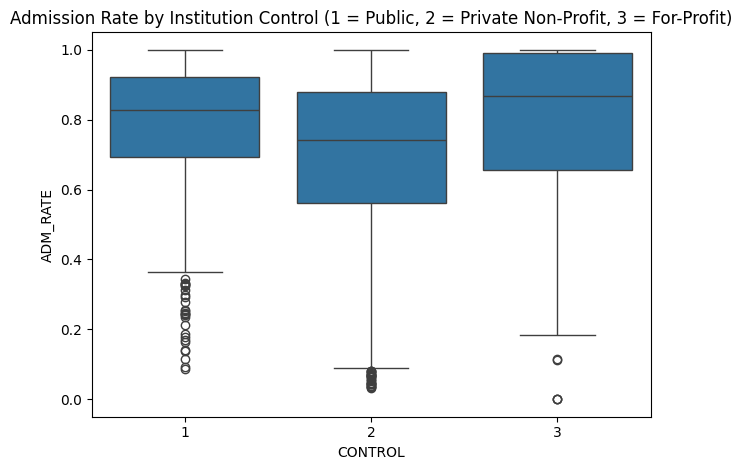

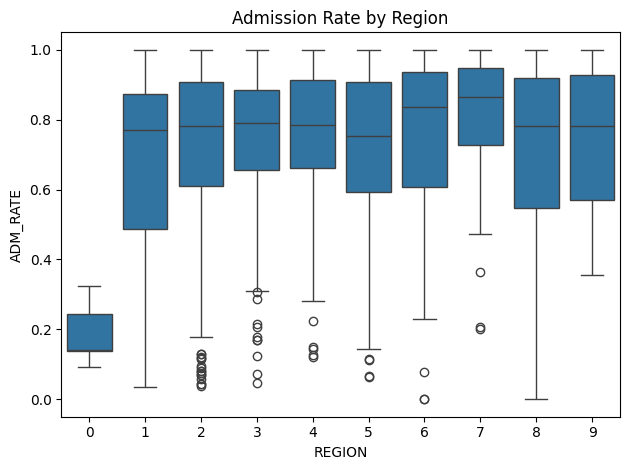

In [27]:
# -------------------------------
# 🔗 Bivariate Analysis: Admission Rate vs Key Predictors
# -------------------------------

# Numeric–numeric
sns.scatterplot(x='SAT_AVG', y='ADM_RATE', data=df)
plt.title("SAT Average vs Admission Rate")
plt.xlabel("SAT_AVG (average SAT score)")
plt.ylabel("Admission Rate")
plt.tight_layout()
plt.show()

sns.scatterplot(x='TUITIONFEE_IN', y='ADM_RATE', data=df)
plt.title("In-State Tuition vs Admission Rate")
plt.xlabel("TUITIONFEE_IN")
plt.ylabel("Admission Rate")
plt.tight_layout()
plt.show()

# Categorical–numeric
sns.boxplot(x='CONTROL', y='ADM_RATE', data=df)
plt.title("Admission Rate by Institution Control (1 = Public, 2 = Private Non-Profit, 3 = For-Profit)")
plt.tight_layout()
plt.show()

sns.boxplot(x='REGION', y='ADM_RATE', data=df)
plt.title("Admission Rate by Region")
plt.tight_layout()
plt.show()


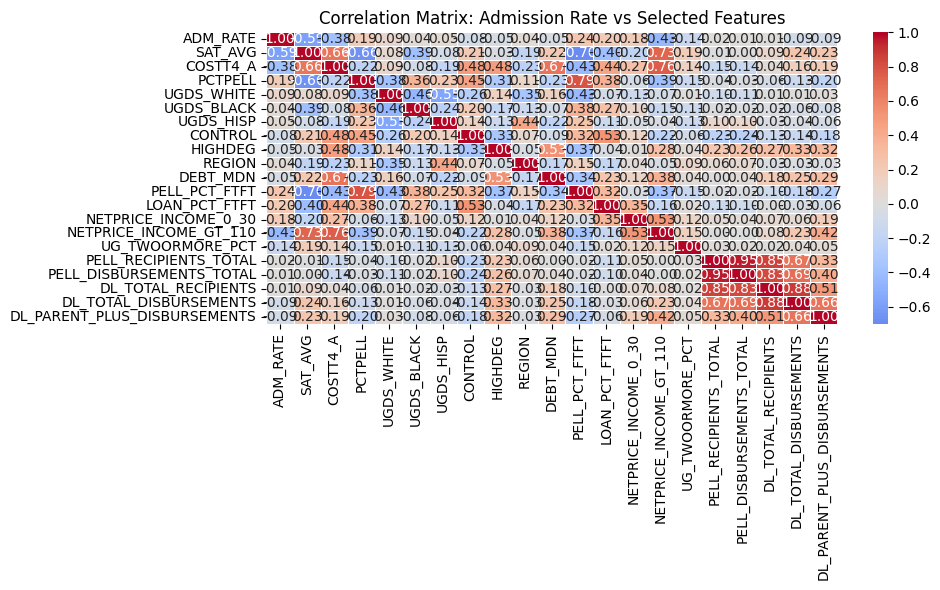

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------------
# 🧼 Clean invalid values before correlation
# -----------------------------------
invalid_values = ["PrivacySuppressed", "PS", "NULL", "NaN", "nan", ".", " "]
df = df.replace(invalid_values, np.nan)

# Only keep numeric columns for correlation
cols_for_corr = ['ADM_RATE'] + selected_features
df_corr = df[cols_for_corr].apply(pd.to_numeric, errors='coerce')

# -----------------------------------
# 🧩 Correlation Matrix
# -----------------------------------
corr = df_corr.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True, fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix: Admission Rate vs Selected Features")
plt.tight_layout()
plt.show()


In [29]:
# ===============================================================
# 🧾 EDA SUMMARY: "WHAT DO WE HAVE?"
# ===============================================================
#
# ✅ DATA OVERVIEW
# ---------------------------------------------------------------
# • The dataset contains 6,429 institutions and 3,221 columns after cleaning.
# • The target variable is `ADM_RATE` (admission rate), with 1,946 valid entries.
# • Data sources: College Scorecard “Most Recent Institutional Data” merged with IPEDS (Final 2023),
#   AY22-23 Pell/TEACH/IASG aggregates, and AY22-23 Direct Loan dashboards.
#   All merges happen via `UNITID`/`OPEID`, then everything is stored in `college_scorecard_enriched.csv` for downstream modeling.
# • Dictionary metadata from the `Institution_Data_Dictionary` sheet is used for typing.
#
# ✅ CLEANING ACTIONS
# ---------------------------------------------------------------
# • Dropped 85 columns with >90% missing values.
# • Replaced invalid entries ("PrivacySuppressed", "NULL", "NaN", ".", etc.) with NaN.
# • Confirmed no duplicate rows were present.
# • Identified numeric anomalies (e.g., negative tuition or NPT values).
#
# ✅ KEY FINDINGS
# ---------------------------------------------------------------
# • Admission rate (ADM_RATE) negatively correlates with average SAT/ACT scores:
#     → Schools with higher SAT/ACT averages tend to be more selective.
# • Public institutions generally show higher admission rates,
#   while private non-profits are more selective.
# • Tuition and total annual cost are strongly correlated (r ≈ 0.97),
#   suggesting one should be dropped to avoid multicollinearity.
# • Percentage of Pell Grant recipients (PCTPELL) negatively correlates with SAT/ACT
#   and selectivity — socioeconomic differences likely play a role.
# • Demographic proportions (UGDS_WHITE, UGDS_BLACK, UGDS_HISP) show weak correlations
#   with admission rate.
#
# ✅ NEXT STEPS
# ---------------------------------------------------------------
# • Refine feature selection — remove redundant or highly correlated predictors 
#   (e.g., COSTT4_A vs TUITIONFEE_IN, SAT_AVG vs ACTCMMID).
# • Handle remaining moderate missingness (<90%).
# • Normalize or scale numerical features before modeling.
# • Prepare final clean dataset for regression/classification model training.
#
# ✅ GUIDELINE CHECKPOINT
# ---------------------------------------------------------------
# • Step 1 (EDA) and Step 2 (Feature Reduction) are completed here with Scorecard + IPEDS + FSA merges.
# • Steps 3–6 (preprocessing, modeling, explainability, conclusions) continue in Notebooks 02–04 per the project plan.
#
# ===============================================================
# ✅ END OF PART 1: EXPLORATORY DATA ANALYSIS
# ===============================================================


In [30]:
clean_features = df[['ADM_RATE'] + selected_features].dropna()
clean_features.to_csv("../Data_Assets/college_scorecard_enriched.csv", index=False)
print("✅ Enriched dataset saved:", clean_features.shape)


✅ Enriched dataset saved: (610, 21)


In [31]:
low_variance = clean_features.loc[:, clean_features.nunique() <= 1]
print("Low-variance columns:", list(low_variance.columns))


Low-variance columns: []


In [32]:
corr_matrix = clean_features.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
high_corr = [column for column in upper.columns if any(upper[column] >= 0.85)]
print("Highly correlated features:", high_corr)


Highly correlated features: ['PELL_PCT_FTFT', 'PELL_DISBURSEMENTS_TOTAL', 'DL_TOTAL_RECIPIENTS', 'DL_TOTAL_DISBURSEMENTS']


In [33]:
corr_target = clean_features.corr()['ADM_RATE'].abs().sort_values(ascending=False)
print(corr_target)


ADM_RATE                        1.000000
SAT_AVG                         0.642439
LOAN_PCT_FTFT                   0.583544
NETPRICE_INCOME_GT_110          0.552408
COSTT4_A                        0.540614
PELL_PCT_FTFT                   0.418554
PCTPELL                         0.377925
NETPRICE_INCOME_0_30            0.376760
UGDS_WHITE                      0.242448
UG_TWOORMORE_PCT                0.232761
DL_TOTAL_DISBURSEMENTS          0.177599
DEBT_MDN                        0.163478
HIGHDEG                         0.161252
DL_PARENT_PLUS_DISBURSEMENTS    0.112739
REGION                          0.112271
DL_TOTAL_RECIPIENTS             0.055523
UGDS_BLACK                      0.047941
UGDS_HISP                       0.045210
PELL_DISBURSEMENTS_TOTAL        0.041305
CONTROL                         0.038433
PELL_RECIPIENTS_TOTAL           0.032526
Name: ADM_RATE, dtype: float64


In [34]:
from sklearn.feature_selection import mutual_info_regression

X = clean_features.drop(columns=['ADM_RATE'])
y = clean_features['ADM_RATE']

mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_series)


SAT_AVG                         0.411519
COSTT4_A                        0.348013
LOAN_PCT_FTFT                   0.297392
NETPRICE_INCOME_GT_110          0.274092
NETPRICE_INCOME_0_30            0.192710
PELL_PCT_FTFT                   0.165522
PCTPELL                         0.162928
UG_TWOORMORE_PCT                0.128616
UGDS_WHITE                      0.123467
REGION                          0.111232
DL_TOTAL_DISBURSEMENTS          0.108206
UGDS_HISP                       0.094132
UGDS_BLACK                      0.068072
DL_TOTAL_RECIPIENTS             0.066935
DEBT_MDN                        0.050467
PELL_DISBURSEMENTS_TOTAL        0.047395
PELL_RECIPIENTS_TOTAL           0.043578
HIGHDEG                         0.038257
DL_PARENT_PLUS_DISBURSEMENTS    0.021223
CONTROL                         0.000003
dtype: float64


In [35]:
# ---------------------------------------
# 🎯 Combine correlation + MI to rank features
# ---------------------------------------
feature_scores = pd.DataFrame({
    'Correlation_with_ADM_RATE': corr_target.drop('ADM_RATE'),
    'Mutual_Info': mi_series
}).sort_values(by='Mutual_Info', ascending=False)

# Show top 15–20 features
print("📊 Top features based on Mutual Information:")
display(feature_scores.head(20))

# Decide which to keep (example threshold)
selected_final = feature_scores.head(15).index.tolist()
print("\n✅ Selected final features:", selected_final)


📊 Top features based on Mutual Information:


,Correlation_with_ADM_RATE,Mutual_Info
SAT_AVG,0.642439,0.411519
COSTT4_A,0.540614,0.348013
LOAN_PCT_FTFT,0.583544,0.297392
NETPRICE_INCOME_GT_110,0.552408,0.274092
NETPRICE_INCOME_0_30,0.376760,0.192710
PELL_PCT_FTFT,0.418554,0.165522
PCTPELL,0.377925,0.162928
UG_TWOORMORE_PCT,0.232761,0.128616
UGDS_WHITE,0.242448,0.123467
REGION,0.112271,0.111232



✅ Selected final features: ['SAT_AVG', 'COSTT4_A', 'LOAN_PCT_FTFT', 'NETPRICE_INCOME_GT_110', 'NETPRICE_INCOME_0_30', 'PELL_PCT_FTFT', 'PCTPELL', 'UG_TWOORMORE_PCT', 'UGDS_WHITE', 'REGION', 'DL_TOTAL_DISBURSEMENTS', 'UGDS_HISP', 'UGDS_BLACK', 'DL_TOTAL_RECIPIENTS', 'DEBT_MDN']


In [36]:
# ---------------------------------------
# 🧹 Remove Highly Correlated Features (|r| >= 0.85)
# ---------------------------------------
print("=" * 60)
print("🔍 Checking for highly correlated feature pairs (|r| >= 0.85)")
print("=" * 60)

# Get correlation matrix for selected features
corr_matrix = clean_features[selected_final].corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find highly correlated pairs
high_corr_pairs = []
for col in upper.columns:
    for idx in upper.index:
        if pd.notna(upper.loc[idx, col]) and upper.loc[idx, col] >= 0.85:
            high_corr_pairs.append((idx, col, upper.loc[idx, col]))

if high_corr_pairs:
    print(f"\n⚠️ Found {len(high_corr_pairs)} highly correlated pair(s):")
    for pair in high_corr_pairs:
        print(f"  {pair[0]} <-> {pair[1]}: r = {pair[2]:.4f}")
    
    # For each pair, keep the one with higher correlation to target
    features_to_remove = []
    target_corr = clean_features[selected_final + ['ADM_RATE']].corr()['ADM_RATE'].abs()
    
    for pair in high_corr_pairs:
        feat1, feat2 = pair[0], pair[1]
        corr1 = target_corr[feat1]
        corr2 = target_corr[feat2]
        
        if corr1 >= corr2:
            features_to_remove.append(feat2)
            print(f"\n  → Keeping '{feat1}' (r={corr1:.4f}), removing '{feat2}' (r={corr2:.4f})")
        else:
            features_to_remove.append(feat1)
            print(f"\n  → Keeping '{feat2}' (r={corr2:.4f}), removing '{feat1}' (r={corr1:.4f})")
    
    # Remove redundant features
    selected_final = [f for f in selected_final if f not in features_to_remove]
    print(f"\n✅ Removed {len(features_to_remove)} redundant feature(s): {features_to_remove}")
    print(f"✅ Final feature count: {len(selected_final)} features")
else:
    print("\n✅ No highly correlated pairs found (all |r| < 0.85)")

print(f"\n📋 Final selected features: {selected_final}")


🔍 Checking for highly correlated feature pairs (|r| >= 0.85)

⚠️ Found 2 highly correlated pair(s):
  PELL_PCT_FTFT <-> PCTPELL: r = 0.9046
  DL_TOTAL_DISBURSEMENTS <-> DL_TOTAL_RECIPIENTS: r = 0.8615

  → Keeping 'PELL_PCT_FTFT' (r=0.4186), removing 'PCTPELL' (r=0.3779)

  → Keeping 'DL_TOTAL_DISBURSEMENTS' (r=0.1776), removing 'DL_TOTAL_RECIPIENTS' (r=0.0555)

✅ Removed 2 redundant feature(s): ['PCTPELL', 'DL_TOTAL_RECIPIENTS']
✅ Final feature count: 13 features

📋 Final selected features: ['SAT_AVG', 'COSTT4_A', 'LOAN_PCT_FTFT', 'NETPRICE_INCOME_GT_110', 'NETPRICE_INCOME_0_30', 'PELL_PCT_FTFT', 'UG_TWOORMORE_PCT', 'UGDS_WHITE', 'REGION', 'DL_TOTAL_DISBURSEMENTS', 'UGDS_HISP', 'UGDS_BLACK', 'DEBT_MDN']


In [37]:
final_df = clean_features[['ADM_RATE'] + selected_final].dropna()
final_df.to_csv("../Data_Assets/college_scorecard_reduced.csv", index=False)
print(f"✅ Reduced dataset saved! Shape: {final_df.shape}")


✅ Reduced dataset saved! Shape: (610, 14)
